In [1]:
# import libraries
import pandas as pd
import scipy.stats
import statsmodels.stats.multitest
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# disable warnings, use w caution
import warnings
warnings.filterwarnings('ignore')

# project specific libs
import os
import matplotlib.pyplot as plt
import pathlib

In [129]:
# set project path
path = '/Users/KevinBu/Desktop/clemente_lab/Projects/twinsra/'

##### MP4 Mapping and Taxa Tables #####

In [3]:
#### take metaphlan file and drop samples 516 and 517
df_mp = pd.read_csv(path + 'inputs/metaphlan_taxa_table.tsv', sep='\t', index_col=0)
df_mp = df_mp.T
# check counts df_mp.sum(axis=1)
df_mp.head()

species,k Archaea|p Candidatus Thermoplasmatota|c Thermoplasmata|o Methanomassiliicoccales|f Methanomassiliicoccaceae|g Methanomassiliicoccaceae unclassified|s Methanomassiliicoccaceae unclassified SGB380,k Archaea|p Euryarchaeota|c Methanobacteria|o Methanobacteriales|f Methanobacteriaceae|g Methanobrevibacter|s Methanobrevibacter smithii,k Archaea|p Thaumarchaeota|c Thaumarchaeota unclassified|o Nitrosopumilales|f Nitrosopumilaceae|g Nitrosopumilus|s Nitrosopumilus SGB14899,k Bacteria|p Actinobacteria|c Actinomycetia|o Actinomycetales|f Actinomycetaceae|g Actinomyces|s Actinomyces SGB17154,k Bacteria|p Actinobacteria|c Actinomycetia|o Actinomycetales|f Actinomycetaceae|g Fannyhessea|s Fannyhessea vaginae,k Bacteria|p Actinobacteria|c Actinomycetia|o Actinomycetales|f Actinomycetaceae|g GGB79819|s GGB79819 SGB4702,k Bacteria|p Actinobacteria|c Actinomycetia|o Actinomycetales|f Actinomycetaceae|g GGB9832|s GGB9832 SGB15478,k Bacteria|p Actinobacteria|c Actinomycetia|o Actinomycetales|f Actinomycetaceae|g Schaalia|s Schaalia turicensis,k Bacteria|p Actinobacteria|c Actinomycetia|o Bifidobacteriales|f Bifidobacteriaceae|g Bifidobacterium|s Bifidobacterium adolescentis,k Bacteria|p Actinobacteria|c Actinomycetia|o Bifidobacteriales|f Bifidobacteriaceae|g Bifidobacterium|s Bifidobacterium animalis,...,k Bacteria|p Proteobacteria|c Gammaproteobacteria|o Enterobacterales|f Enterobacteriaceae|g Klebsiella|s Klebsiella variicola,k Bacteria|p Proteobacteria|c Gammaproteobacteria|o Moraxellales|f Moraxellaceae|g Acinetobacter|s Acinetobacter SGB14792,k Bacteria|p Proteobacteria|c Gammaproteobacteria|o Moraxellales|f Moraxellaceae|g GGB72452|s GGB72452 SGB4052,k Bacteria|p Proteobacteria|c Gammaproteobacteria|o Pasteurellales|f Pasteurellaceae|g Haemophilus|s Haemophilus SGB47419,k Bacteria|p Proteobacteria|c Gammaproteobacteria|o Pasteurellales|f Pasteurellaceae|g Haemophilus|s Haemophilus parainfluenzae,k Bacteria|p Synergistetes|c Synergistia|o Synergistales|f Synergistaceae|g GGB9469|s GGB9469 SGB14863,k Bacteria|p Tenericutes|c CFGB1787|o OFGB1787|f FGB1787|g GGB4745|s GGB4745 SGB6570,k Bacteria|p Verrucomicrobia|c Verrucomicrobiae|o Verrucomicrobiales|f Akkermansiaceae|g Akkermansia|s Akkermansia muciniphila,k Bacteria|p Verrucomicrobia|c Verrucomicrobiae|o Verrucomicrobiales|f Akkermansiaceae|g Akkermansia|s Akkermansia sp BIOML A40,k Bacteria|p Verrucomicrobia|c Verrucomicrobiae|o Verrucomicrobiales|f Akkermansiaceae|g Akkermansia|s Akkermansia sp KLE1798
500A,0.0,431.0,0.0,0.0,0.0,0.0,0.0,0.0,4350.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
501A,3299.0,157290.0,0.0,0.0,0.0,0.0,0.0,0.0,12451.0,0.0,...,0.0,7046.0,2143.0,0.0,9971.0,0.0,0.0,129889.0,0.0,0.0
502A,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
503A,0.0,0.0,0.0,0.0,780.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
504A,0.0,0.0,17148.0,0.0,0.0,0.0,0.0,0.0,45062.0,9347.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,194671.0,0.0


In [4]:
# rename without Fecal suffix for ensemble fastq's
# grab mapping file, partition samples and controls
df_map = pd.read_csv(path + 'inputs/Qiime2_0_KB/qiime_mapping_file_noctrl_no182183.tsv', sep='\t', index_col=0)
df_map = df_map.reset_index()
new_sid = [x.replace('.Fecal','') for x in list(df_map['#SampleID'].values)]
df_map['#SampleID'] = new_sid
df_map = df_map.set_index('#SampleID')
df_map.to_csv(path + 'inputs/Qiime2_1_KB/qiime_mapping_file_noctrl_no182183_ensemble.tsv', sep='\t')

# create new ensemble mapping file for Q2
df_map = pd.read_csv(path + 'inputs/qiime_mapping_file_noctrl_no182183_ensemble.tsv', sep='\t', index_col=0)
df_map = df_map.drop(['516A','517A'])
df_map.to_csv(path + 'inputs/qiime_mapping_file_noctrl_no182183_no516517_ensemble.tsv', sep='\t', index=True)
df_map.head()

,BarcodeSequence,LinkerPrimerSequence,Separate,SomeOtherInfo,Together,TwinPair,AliquotID,AliquotWeight,AliquotWeightUnit,SpecimenBodySite,...,StudyType,SubjectType,BirthYear,HostSubjectId,Nationality,Sex,SpecimenType,UberonCodeType,Weight,WeightDateCollected
#SampleID,,,,,,,,,,,,,,,,,,,,,
#q2:types,categorical,categorical,categorical,categorical,categorical,categorical,categorical,categorical,categorical,categorical,...,categorical,categorical,categorical,categorical,categorical,categorical,categorical,categorical,categorical,categorical
500A,GTTATGACGGAT,CCGGACTACHVGGGTWTCTAAT,Limit 45 Characters,NaN,500A.Fecal,T2,NaN,NaN,NaN,NaN,...,NaN,Human,NaN,500,NaN,NaN,fecal,NaN,NaN,NaN
501A,CCAATGATAAGC,CCGGACTACHVGGGTWTCTAAT,All,NaN,501A.Fecal,T2,NaN,NaN,NaN,NaN,...,NaN,Human,NaN,501,NaN,NaN,fecal,NaN,NaN,NaN
502A,TCAATGACCGCA,CCGGACTACHVGGGTWTCTAAT,All,NaN,502A.Fecal,T3,NaN,NaN,NaN,NaN,...,NaN,Human,NaN,502,NaN,NaN,fecal,NaN,NaN,NaN
503A,CTCTCATATGCT,CCGGACTACHVGGGTWTCTAAT,All,NaN,503A.Fecal,T3,NaN,NaN,NaN,NaN,...,NaN,Human,NaN,503,NaN,NaN,fecal,NaN,NaN,NaN


In [5]:
# read in metaphlan taxa table
# both appear to be abs
df_otu = pd.read_csv(path + 'outputs/jobs00/metaphlan_taxa_table_abs.tsv', sep='\t', index_col=0)

# create taxonomy file
df_taxa = df_otu.reset_index()

# copy species column
df_taxa.iloc[:,1] = df_taxa['species'].values

# rename columns
df_taxa = df_taxa.rename({'species': 'Feature ID','500A': 'Taxon', '501A': 'Confidence'},axis='columns')

# set confidence level
df_taxa['Confidence'] = 0.99

# remove remaining columns
df_taxa = df_taxa.iloc[:,:3]

# set index
df_taxa = df_taxa.set_index('Feature ID')

# format taxa column
df_taxa['Taxon'] = df_taxa['Taxon'].map(lambda x: x.replace(' ','_'))
df_taxa['Taxon'] = df_taxa['Taxon'].map(lambda x: x.replace('|','; '))
#df_taxa['Taxon'] = df_taxa['Taxon'].map(lambda x: 'g__' + x)
#df_taxa['Taxon'] = df_taxa['Taxon'].map(lambda x: x.replace(' ', ';s__'))

# export as tsv
df_taxa.to_csv(path + 'outputs/jobs03/df_taxonomy.tsv', sep='\t')

# transpose and normalize
df_otu = df_otu.T
df_otu = df_otu.div(df_otu.sum(axis=1),axis=0)

# grab top 100
sorted_means = df_otu.mean(axis=0).sort_values(ascending=False)
top_100 = sorted_means[:100].index.values
df_otu_top100 = df_otu.loc[:,top_100]
df_otu_top100.to_csv(path + 'inputs/df_otu_top100.tsv' ,sep='\t')

df_otu.to_csv(path + 'inputs/df_otu_mp4.tsv' ,sep='\t')
df_otu.head()

species,k Archaea|p Candidatus Thermoplasmatota|c Thermoplasmata|o Methanomassiliicoccales|f Methanomassiliicoccaceae|g Methanomassiliicoccaceae unclassified|s Methanomassiliicoccaceae unclassified SGB380,k Archaea|p Euryarchaeota|c Methanobacteria|o Methanobacteriales|f Methanobacteriaceae|g Methanobrevibacter|s Methanobrevibacter smithii,k Archaea|p Thaumarchaeota|c Thaumarchaeota unclassified|o Nitrosopumilales|f Nitrosopumilaceae|g Nitrosopumilus|s Nitrosopumilus SGB14899,k Bacteria|p Actinobacteria|c Actinomycetia|o Actinomycetales|f Actinomycetaceae|g Actinomyces|s Actinomyces SGB17154,k Bacteria|p Actinobacteria|c Actinomycetia|o Actinomycetales|f Actinomycetaceae|g Fannyhessea|s Fannyhessea vaginae,k Bacteria|p Actinobacteria|c Actinomycetia|o Actinomycetales|f Actinomycetaceae|g GGB79819|s GGB79819 SGB4702,k Bacteria|p Actinobacteria|c Actinomycetia|o Actinomycetales|f Actinomycetaceae|g GGB9832|s GGB9832 SGB15478,k Bacteria|p Actinobacteria|c Actinomycetia|o Actinomycetales|f Actinomycetaceae|g Schaalia|s Schaalia turicensis,k Bacteria|p Actinobacteria|c Actinomycetia|o Bifidobacteriales|f Bifidobacteriaceae|g Bifidobacterium|s Bifidobacterium adolescentis,k Bacteria|p Actinobacteria|c Actinomycetia|o Bifidobacteriales|f Bifidobacteriaceae|g Bifidobacterium|s Bifidobacterium animalis,...,k Bacteria|p Proteobacteria|c Gammaproteobacteria|o Enterobacterales|f Enterobacteriaceae|g Klebsiella|s Klebsiella variicola,k Bacteria|p Proteobacteria|c Gammaproteobacteria|o Moraxellales|f Moraxellaceae|g Acinetobacter|s Acinetobacter SGB14792,k Bacteria|p Proteobacteria|c Gammaproteobacteria|o Moraxellales|f Moraxellaceae|g GGB72452|s GGB72452 SGB4052,k Bacteria|p Proteobacteria|c Gammaproteobacteria|o Pasteurellales|f Pasteurellaceae|g Haemophilus|s Haemophilus SGB47419,k Bacteria|p Proteobacteria|c Gammaproteobacteria|o Pasteurellales|f Pasteurellaceae|g Haemophilus|s Haemophilus parainfluenzae,k Bacteria|p Synergistetes|c Synergistia|o Synergistales|f Synergistaceae|g GGB9469|s GGB9469 SGB14863,k Bacteria|p Tenericutes|c CFGB1787|o OFGB1787|f FGB1787|g GGB4745|s GGB4745 SGB6570,k Bacteria|p Verrucomicrobia|c Verrucomicrobiae|o Verrucomicrobiales|f Akkermansiaceae|g Akkermansia|s Akkermansia muciniphila,k Bacteria|p Verrucomicrobia|c Verrucomicrobiae|o Verrucomicrobiales|f Akkermansiaceae|g Akkermansia|s Akkermansia sp BIOML A40,k Bacteria|p Verrucomicrobia|c Verrucomicrobiae|o Verrucomicrobiales|f Akkermansiaceae|g Akkermansia|s Akkermansia sp KLE1798
500A,0.000000,0.000030,0.00000,0.0,0.000000,0.0,0.0,0.0,0.000299,0.000000,...,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0
501A,0.000239,0.011409,0.00000,0.0,0.000000,0.0,0.0,0.0,0.000903,0.000000,...,0.0,0.000511,0.000155,0.0,0.000723,0.0,0.0,0.009421,0.000000,0.0
502A,0.000000,0.000000,0.00000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0
503A,0.000000,0.000000,0.00000,0.0,0.000075,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0
504A,0.000000,0.000000,0.00129,0.0,0.000000,0.0,0.0,0.0,0.003391,0.000703,...,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.014649,0.0


In [6]:
# grab mapping file, partition samples and controls
df_map = pd.read_csv(path + 'inputs/qiime_mapping_file_noctrl_no182183_no516517_ensemble.tsv', sep='\t', index_col=0)

# get first row for any future operations
first_row = df_map.reset_index().iloc[0,]
first_row_df = pd.DataFrame(first_row).T
df_map = df_map.iloc[1:,]

# remove separate and together columns
df_map = df_map.drop(['Separate','Together'], axis=1)

# subset on useful columns
# TwinPair and Diagnosis are useful columns
df_map = df_map.loc[:,['TwinPair','Diagnosis']]

df_map.head()

,TwinPair,Diagnosis
#SampleID,,
500A,T2,RA
501A,T2,Unaffected
502A,T3,RA
503A,T3,Unaffected
504A,T4,RA


In [7]:
# q2R for stacked barplot
RA = list(df_map[df_map['Diagnosis'] == 'RA'].index.values)
UA = list(df_map[df_map['Diagnosis'] == 'Unaffected'].index.values)

df_q2R = df_otu.copy().T
df_q2R['UA_mean'] = df_q2R[UA].mean(axis=1)
df_q2R['RA_mean'] = df_q2R[RA].mean(axis=1)
df_q2R = df_q2R[['RA_mean','UA_mean']]
df_q2R.index.name = 'Species'
df_q2R.index = df_q2R.index.map(lambda x: x.split('|s')[1])
df_q2R.to_csv(path + 'inputs/df_q2R.tsv', sep='\t')
df_q2R.head()
# df_q2R
#df_q2R.sort_values(by='RA_mean',ascending=False).iloc[0:10,:]


,RA_mean,UA_mean
Species,,
Methanomassiliicoccaceae unclassified SGB380,0.000000,0.000030
Methanobrevibacter smithii,0.000582,0.001441
Nitrosopumilus SGB14899,0.000361,0.000072
Actinomyces SGB17154,0.000003,0.000000
Fannyhessea vaginae,0.000000,0.000009


##### Alpha and Beta Div #####

0.4605094942007545 0.6591148429056253
17.0 0.9453125


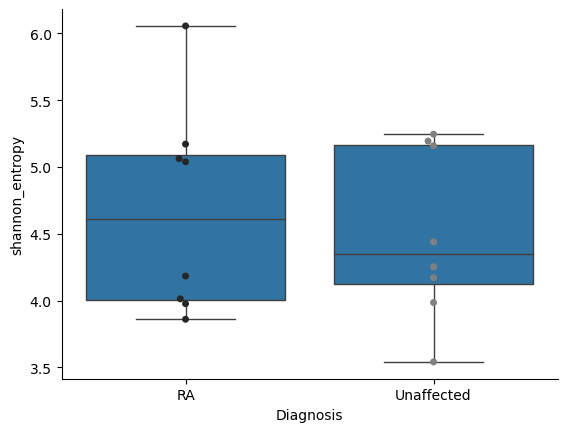

In [8]:
# paired shannon diversity difference from 0 
# this is from shannon_significance.qzv -> download as tsv
df_alpha = pd.read_csv(path + 'outputs/jobs02/metadata_shannon.tsv', sep='\t', index_col=0)
# df_alpha = pd.read_csv(path + 'outputs/jobs02/metadata_chao1.tsv', sep='\t', index_col=0)
# df_alpha = pd.read_csv(path + 'outputs/jobs02/metadata_observed.tsv', sep='\t', index_col=0)
# df_alpha = pd.read_csv(path + 'outputs/jobs02/metadata_evenness.tsv', sep='\t', index_col=0)

alpha_metric = 'shannon_entropy'
# alpha_metric = 'pielou_evenness' # n.s. except for diff alpha
# alpha_metric = 'observed_features' # n.s.
# alpha_metric = 'chao1' # n.s.



# drop unnecessary rows and cols
df_alpha = df_alpha.drop('#q2:types')
df_alpha = df_alpha.drop('Separate', axis=1)

# get paired per twin pair
pair_to_diff = {}
for p in list(df_alpha.TwinPair.values):
    df = df_alpha[df_alpha['TwinPair'] == p]
    alpha_UA = float(df[df['Diagnosis'] == 'Unaffected'][alpha_metric].values)
    alpha_RA = float(df[df['Diagnosis'] == 'RA'][alpha_metric].values)
    pair_to_diff[p] = alpha_RA - alpha_UA

df_paired_alpha = pd.DataFrame.from_dict(pair_to_diff, orient='index', columns=[alpha_metric + '_diff'])

# one-sided t-test, n.s.; RA-UA values 
t, p = scipy.stats.ttest_1samp(df_paired_alpha[alpha_metric + '_diff'],popmean=0)
print(t, p)

m, p = scipy.stats.wilcoxon(df_paired_alpha[alpha_metric + '_diff'])
print(m, p)

# boxplot of differences
#sns.boxplot(data=df_paired_alpha)
#sns.swarmplot(data=df_paired_alpha, palette='dark:grey')
#sns.despine()

# separate
df_alpha[alpha_metric] = df_alpha[alpha_metric].map(lambda x: float(x))
ax = sns.boxplot(data=df_alpha, x='Diagnosis', y=alpha_metric)
sns.swarmplot(data=df_alpha, x='Diagnosis', y=alpha_metric, palette='dark:grey')
sns.despine()

In [9]:
# process beta ordination for R plotting
df_pc = pd.read_csv(path + 'outputs/jobs02/Q2_outputs/ordination.txt', sep='\t', skiprows=9)

# set index to first sample and drop last two metadata rows
df_pc = df_pc.set_index('500A') 
df_pc = df_pc.iloc[:-2,:]

# create new row from column names and replace old col names
df_pc.loc['500A'] = df_pc.columns.values  # adding a row
df_pc.columns = ['PC' + str(i+1) for i in range(len(df_pc.columns))]
df_pc.index.name = 'SampleID'

# merge with metadata
df_pc = pd.concat([df_pc, df_map], axis=1)
df_pc['sib_02'] = df_pc['TwinPair'].map(lambda x: 'MisDx' if x == 'T3' else 'CorrectDx')
df_pc.to_csv(path + 'outputs/jobs02/bray_curtis_pcoa.tsv', sep='\t')
df_pc.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16,TwinPair,Diagnosis,sib_02
501A,-0.064242,0.204422,0.004331,0.0605,-0.104939,-0.191733,-0.062688,-0.144355,0.216428,0.173113,0.053189,0.075915,0.00359,-0.034984,-0.025506,-0.0,T2,Unaffected,CorrectDx
502A,-0.232621,-0.057078,-0.131391,0.044585,0.020252,-0.152454,0.05447,-0.073076,-0.123425,-0.096711,-0.124822,0.036416,0.092423,-0.100855,-0.065866,-0.0,T3,RA,MisDx
503A,-0.271498,-0.158031,-0.053222,0.026877,0.086599,-0.095532,0.038394,0.054045,-0.0398,0.12725,0.106447,-0.177049,0.10352,0.007377,0.054464,-0.0,T3,Unaffected,MisDx
504A,-0.111142,-0.222525,-0.105657,0.199485,0.006978,-0.037698,0.046442,0.312272,0.087048,-0.059049,0.075261,0.124197,-0.030614,0.009814,-0.016471,-0.0,T4,RA,CorrectDx
505A,-0.201807,-0.003872,-0.022754,-0.262292,0.09817,0.087379,-0.128997,0.034522,-0.004889,0.035228,-0.080164,0.128241,-0.008776,-0.060466,0.106393,-0.0,T4,Unaffected,CorrectDx


3.8205185439560694 0.14804199847741845


<Axes: xlabel='category', ylabel='distance'>

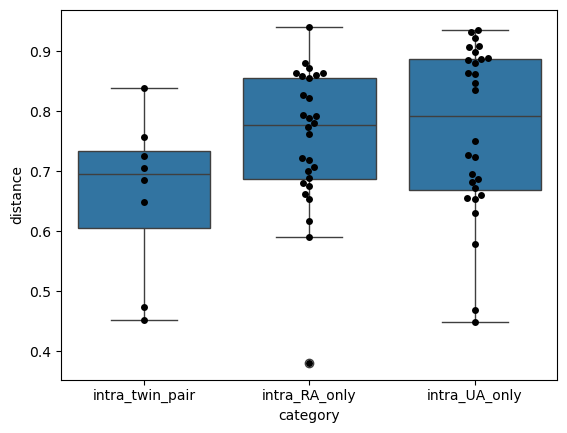

In [10]:
# paired beta div: unweighted distances to compare inter-twin vs inter-disease distances
# paired shannon diversity difference from 0 
df_beta = pd.read_csv(path + 'outputs/jobs02/Q2_outputs/bray_curtis_distance_matrix.tsv',
                      sep='\t', index_col=0)

# grab twin to pair dict
pair_to_ids = {}
for p in list(df_alpha.TwinPair.values):
    df = df_alpha[df_alpha['TwinPair'] == p]
    id_UA = str(df[df['Diagnosis'] == 'Unaffected'].index.values[0])
    id_RA = str(df[df['Diagnosis'] == 'RA'].index.values[0])
    pair_to_ids[p] = (id_UA, id_RA)

# get distances for each twin pair per beta div matrix    
pair_to_dist = {}
for p in list(df_alpha.TwinPair.values):
    id_UA, id_RA = pair_to_ids[p]
    pair_to_dist[p] = df_beta.loc[id_UA, id_RA]

df_paired_beta = pd.DataFrame.from_dict(pair_to_dist, orient='index', columns=['Bray_Curtis'])

# grab inter RA distances
# this is from bray_curtis_significance_Diagnosis.qzv -> download as tsv
df_raw = pd.read_csv(path + 'outputs/jobs02/bray_curtis_raw_data.tsv', 
                     sep='\t', index_col=0)
df_RA = df_raw[df_raw['Group1'] == 'RA']
df_RA = df_RA[df_RA['Group2'] == 'RA']
df_UA = df_raw[df_raw['Group1'] == 'Unaffected']
df_UA = df_UA[df_UA['Group2'] == 'Unaffected']

# compare distances
inter_twin = df_paired_beta['Bray_Curtis'].values
inter_RA = df_RA['Distance'].values
inter_UA = df_UA['Distance'].values

u, p = scipy.stats.kruskal(inter_UA, inter_RA, inter_twin)
print(u, p)

u, p = scipy.stats.mannwhitneyu(inter_twin, inter_RA)
# print(u, p)

t, p = scipy.stats.ttest_ind(inter_twin, inter_RA)
#print(t, p)

t, p = scipy.stats.ttest_ind(inter_UA, inter_RA)
# print(t, p)

f, p = scipy.stats.f_oneway(inter_UA, inter_RA, inter_twin)
# print(f, p)

category = ['intra_twin_pair']*len(inter_twin) + ['intra_RA_only']*len(inter_RA) + ['intra_UA_only']*len(inter_UA)
distances = list(inter_twin) + list(inter_RA) + list(inter_UA)
df_dist = pd.DataFrame(data=np.array([category,distances]).T, columns=['category','distance'])
df_dist['distance'] = df_dist['distance'].astype(float)
df_dist.to_csv(path + 'outputs/jobs02/intra_beta_dist.tsv',sep='\t')
                     
sns.boxplot(data=df_dist, x='category', y='distance')
sns.swarmplot(data=df_dist, x='category', y='distance', color='black')

0.8010989010989249 0.669951839482939


<Axes: xlabel='category', ylabel='distance'>

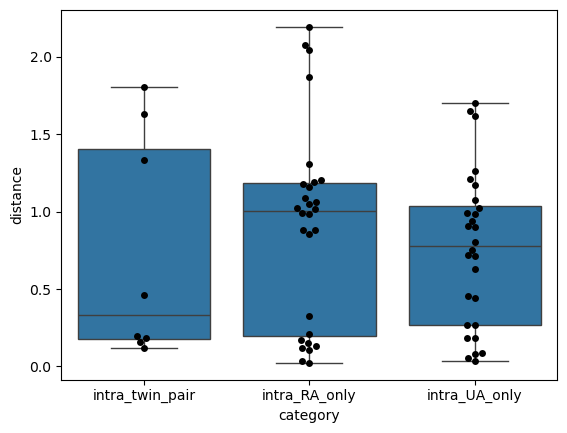

In [11]:
# paired alpha div: unweighted distances to compare inter-twin vs inter-disease distances
# paired shannon diversity difference from 0 
# grab twin to pair dict
# get distances for each twin pair per beta div matrix    
pair_to_dist = {}
for p in list(df_alpha.TwinPair.values):
    id_UA, id_RA = pair_to_ids[p]
    pair_to_dist[p] = df_alpha.loc[id_RA,alpha_metric] - df_alpha.loc[id_UA,alpha_metric]
    
df_alpha_inter = pd.DataFrame.from_dict(pair_to_dist, orient='index', columns=[alpha_metric])

# grab inter RA distances
df_RA = df_alpha[df_alpha['Diagnosis'] == 'RA']
RA_divs = list(df_RA[alpha_metric].values)
RA_diffs = [np.abs(x - y) for i,x in enumerate(RA_divs) for j,y in enumerate(RA_divs) if i < j]

# grab inter UA distances
df_UA = df_alpha[df_alpha['Diagnosis'] == 'Unaffected']
UA_divs = list(df_UA[alpha_metric].values)
UA_diffs = [np.abs(x - y) for i,x in enumerate(UA_divs) for j,y in enumerate(UA_divs) if i < j]

# compare distances
inter_twin = np.abs(df_alpha_inter[alpha_metric].values)
inter_RA = list(RA_diffs)
inter_UA = list(UA_diffs)

u, p = scipy.stats.kruskal(inter_UA, inter_RA, inter_twin)
print(u, p)

u, p = scipy.stats.mannwhitneyu(inter_twin, inter_RA)
# print(u, p)

t, p = scipy.stats.ttest_ind(inter_twin, inter_RA)
# print(t, p)

f, p = scipy.stats.f_oneway(inter_UA, inter_RA, inter_twin)
# print(f, p)

category = ['intra_twin_pair']*len(inter_twin) + ['intra_RA_only']*len(inter_RA) + ['intra_UA_only']*len(inter_UA)
distances = list(inter_twin) + list(inter_RA) + list(inter_UA)
df_dist = pd.DataFrame(data=np.array([category,distances]).T, columns=['category','distance'])
df_dist['distance'] = df_dist['distance'].astype(float)
df_dist.to_csv(path + 'outputs/jobs02/intra_alpha_dist.tsv',sep='\t')

sns.boxplot(data=df_dist, x='category', y='distance')
sns.swarmplot(data=df_dist, x='category', y='distance', color='black')

##### MTX Usage #####

10.0 0.5714285714285714
0.7847404067976351 0.4624554060605416
0.09587007560175183 0.08939238572334704
1.7347641269240992 0.23586737222279144


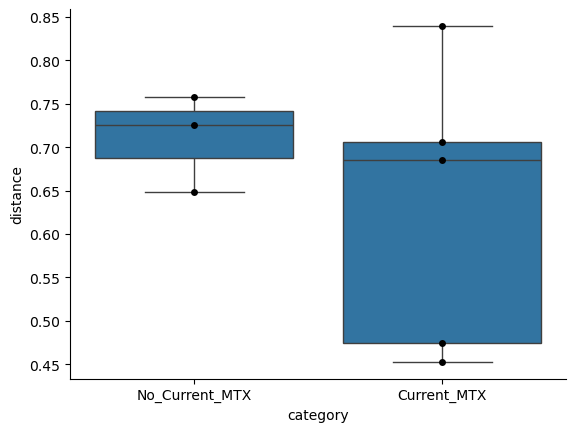

In [12]:
# investigate whether MTX treated twins converge to unaffected twins

# manually input metadata from Patient_data_KB.xls
samp_to_MTX = {
    '500A': 1,
    '502A': 1,
    '504A': 1,
    '506A': 0, # other DMARDs
    '508A': 0, # unclear? HCQ
    '510A': 1,
    '512A': 1,
    '514A': 0#, # previosuly, not currently
    #'516A.Fecal': 0, # in 2012, not currently,
}
# present MTX vs present biologic?
# to treatment
samp_to_tmt = {
    '500A': 1, # MTX
    '502A': 1, # MTX
    '504A': 1, # MTX
    '506A': 1, # other DMARDs
    '508A': 1, # on HCQ
    '510A': 1,
    '512A': 1,
    '514A': 0#, # previously, not currently
    #'516A.Fecal': 0, # in 2012, not currently,
}

# get copy
df_meta = df_map.copy()

# replace with column dict per above
df_meta['MTX'] = df_meta.index.map(samp_to_MTX)

# replace nan with 0 i.e. untreated
df_meta['MTX'] = df_meta['MTX'].fillna(0) 

# copy for future
df_med = df_meta.copy()

# create TwinPair to MTX mapping
df = df_meta[df_meta['Diagnosis'] == 'RA'].set_index('TwinPair')
TP_to_MTX = df['MTX'].to_dict()

# Things to ask
# 1. Do the twin pair distances decrease in treated vs untreated twins?
df_paired_beta['MTX'] = df_paired_beta.index.map(TP_to_MTX)

# compare distances
inter_untreated = df_paired_beta[df_paired_beta['MTX'] == 0]['Bray_Curtis']
inter_treated = df_paired_beta[df_paired_beta['MTX'] == 1]['Bray_Curtis']

u, p = scipy.stats.mannwhitneyu(inter_untreated, inter_treated)
print(u, p)

t, p = scipy.stats.ttest_ind(inter_untreated, inter_treated)
print(t, p)

# sns.boxplot([inter_untreated, inter_treated])

category = ['No_Current_MTX']*len(inter_untreated) + ['Current_MTX']*len(inter_treated)
distances = list(inter_untreated) + list(inter_treated)
df_dist = pd.DataFrame(data=np.array([category,distances]).T, columns=['category','distance'])
df_dist['distance'] = df_dist['distance'].astype(float)

# f test of variance

F = np.var(inter_untreated) / np.var(inter_treated)
df1 = len(inter_untreated) - 1
df2 = len(inter_treated) - 1

p_value = scipy.stats.f.cdf(F, df1, df2)

print(F,p_value)

# levene test non parametric
l, p  = scipy.stats.levene(inter_untreated, inter_treated)
print(l, p)

sns.boxplot(data=df_dist, x='category', y='distance')
sns.swarmplot(data=df_dist, x='category', y='distance', color='black')

df_dist = df_dist.rename(columns={'category':'MTX', 'distance': 'Bray_Curtis'})
# df_dist['MTX'] = df_dist['MTX'].map(lambda x: 'No_Current_MTX' if int(x) == 0 else 'Current_MTX')
df_dist.to_csv(path + 'outputs/jobs02/beta_MTX.tsv',sep='\t')

sns.despine()

11.0 0.39285714285714285
0.6711590447710831 0.5270980576728104
0.8890306398926742 0.5207570909770318


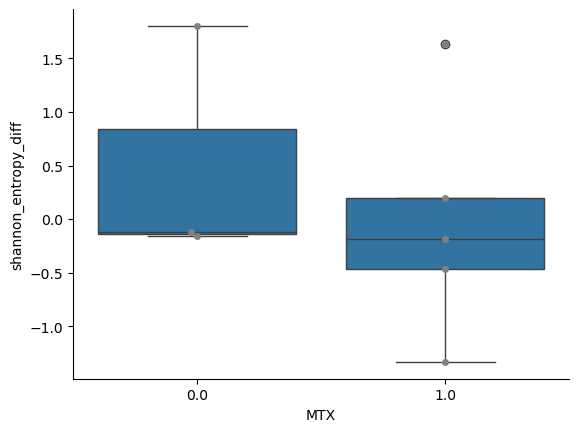

In [13]:
# compare distances
df_paired_div = pd.concat([df_paired_alpha, df_paired_beta], axis=1)

inter_untreated = df_paired_div[df_paired_div['MTX'] == 0][alpha_metric + '_diff']
inter_treated = df_paired_div[df_paired_div['MTX'] == 1][alpha_metric + '_diff']

u, p = scipy.stats.mannwhitneyu(inter_untreated, inter_treated)
print(u, p)

t, p = scipy.stats.ttest_ind(inter_untreated, inter_treated)
print(t, p)

# f test of variance

F = np.var(inter_untreated) / np.var(inter_treated)
df1 = len(inter_untreated) - 1
df2 = len(inter_treated) - 1

p_value = scipy.stats.f.cdf(F, df1, df2)

print(F,p_value)

#sns.boxplot([inter_untreated, inter_treated])
ax = sns.boxplot(data=df_paired_div, x='MTX', y=alpha_metric + '_diff')
sns.swarmplot(data=df_paired_div, x='MTX', y=alpha_metric + '_diff', color='grey')
df_paired_div['MTX'] = df_paired_div['MTX'].map(lambda x: 'No_Current_MTX' if x == 0 else 'Current_MTX')
df_paired_div.to_csv(path + 'outputs/jobs02/alpha_MTX.tsv',sep='\t')

sns.despine()

##### SJC TJC #####

In [14]:
# add in metadata TJC and SJC
samp_to_TJC = {
    '501A': 0,
    '503A': 2,
    '505A': 8,
    '507A': 0,
    '509A': 0,
    '511A': 0,
    '513A': 0,
    '515A': 0,
    '500A': 1, 
    '502A': 7, 
    '504A': 25, 
    '506A': 21, 
    '508A': 13,
    '510A': 0,
    '512A': 4,
    '514A': 12
}

samp_to_SJC = {
    '501A': 0,
    '503A': 0,
    '505A': 2,
    '507A': 0,
    '509A': 0,
    '511A': 0,
    '513A': 0,
    '515A': 0,
    '500A': 1, 
    '502A': 7, 
    '504A': 27, 
    '506A': 3, 
    '508A': 6,
    '510A': 0,
    '512A': 1,
    '514A': 5
}

# why is 510 so well controlled...? even w/o steroids
# Actinomycetales?

# correlate SJC/TJC with distance
df_meta = df_map.copy()

# replace with column dict per above
df_meta['TJC'] = df_meta.index.map(samp_to_TJC)
df_meta['SJC'] = df_meta.index.map(samp_to_SJC)

# create TwinPair to var mapping
df = df_meta[df_meta['Diagnosis'] == 'RA'].set_index('TwinPair')
TP_to_TJC = df['TJC'].to_dict()
TP_to_SJC = df['SJC'].to_dict()

# create column in paired beta
df_paired_beta['SJC'] = df_paired_beta.index.map(TP_to_SJC)
df_paired_beta['TJC'] = df_paired_beta.index.map(TP_to_TJC)

df_paired_beta.head()

,Bray_Curtis,MTX,SJC,TJC
T2,0.705551,1.0,1,1
T3,0.474034,1.0,7,7
T4,0.685602,1.0,27,25
T5,0.725669,0.0,3,21
T6,0.757568,0.0,6,13


In [15]:
# conduct correlation
'''
r, p = scipy.stats.pearsonr(x=df_paired_beta['Bray_Curtis'],y=df_paired_beta['SJC'])
sns.lmplot(data=df_paired_beta, x='Bray_Curtis', y='SJC')
print(r, p)

r, p = scipy.stats.pearsonr(x=df_paired_beta['Bray_Curtis'],y=df_paired_beta['TJC'])
sns.lmplot(data=df_paired_beta, x='Bray_Curtis', y='TJC')
print(r, p)

r, p = scipy.stats.spearmanr(a=df_paired_beta['Bray_Curtis'],b=df_paired_beta['SJC'])
print(r, p)

r, p = scipy.stats.spearmanr(a=df_paired_beta['Bray_Curtis'],b=df_paired_beta['TJC'])
print(r, p)

# alpha version of plot
df_paired_div = pd.concat([df_paired_alpha, df_paired_beta], axis=1)

r, p = scipy.stats.pearsonr(x=df_paired_div[alpha_metric + '_diff'],y=df_paired_div['TJC'])
sns.lmplot(data=df_paired_div, x=alpha_metric + '_diff', y='TJC')
print(r, p)

r, p = scipy.stats.pearsonr(x=df_paired_div[alpha_metric + '_diff'],y=df_paired_div['SJC'])
sns.lmplot(data=df_paired_div, x=alpha_metric + '_diff', y='SJC')
print(r, p)

r, p = scipy.stats.spearmanr(a=df_paired_div[alpha_metric + '_diff'],b=df_paired_div['TJC'])
print(r, p)

r, p = scipy.stats.spearmanr(a=df_paired_div[alpha_metric + '_diff'],b=df_paired_div['SJC'])
print(r, p)
'''

"\nr, p = scipy.stats.pearsonr(x=df_paired_beta['Bray_Curtis'],y=df_paired_beta['SJC'])\nsns.lmplot(data=df_paired_beta, x='Bray_Curtis', y='SJC')\nprint(r, p)\n\nr, p = scipy.stats.pearsonr(x=df_paired_beta['Bray_Curtis'],y=df_paired_beta['TJC'])\nsns.lmplot(data=df_paired_beta, x='Bray_Curtis', y='TJC')\nprint(r, p)\n\nr, p = scipy.stats.spearmanr(a=df_paired_beta['Bray_Curtis'],b=df_paired_beta['SJC'])\nprint(r, p)\n\nr, p = scipy.stats.spearmanr(a=df_paired_beta['Bray_Curtis'],b=df_paired_beta['TJC'])\nprint(r, p)\n\n# alpha version of plot\ndf_paired_div = pd.concat([df_paired_alpha, df_paired_beta], axis=1)\n\nr, p = scipy.stats.pearsonr(x=df_paired_div[alpha_metric + '_diff'],y=df_paired_div['TJC'])\nsns.lmplot(data=df_paired_div, x=alpha_metric + '_diff', y='TJC')\nprint(r, p)\n\nr, p = scipy.stats.pearsonr(x=df_paired_div[alpha_metric + '_diff'],y=df_paired_div['SJC'])\nsns.lmplot(data=df_paired_div, x=alpha_metric + '_diff', y='SJC')\nprint(r, p)\n\nr, p = scipy.stats.spearma

In [16]:
# get alpha against TJC/SJC
df_meta_new = df_meta.copy()
df_meta_new.index = df_meta_new.index.map(lambda x: x.split('.')[0])
df_meta_new = df_meta_new.drop(['Diagnosis','TwinPair','TJC','SJC','Diagnosis'],axis=1)
df = pd.concat([df_meta_new,df_alpha], axis=1)
df = df[df['Diagnosis'] == 'RA'].set_index('TwinPair')
df = pd.concat([df,df_paired_beta],axis=1)
df = df.drop('Diagnosis',axis=1)
df.to_csv(path + 'outputs/jobs02/df_beta_meta.tsv',sep='\t')



In [17]:
# get alpha against TJC/SJC
df_meta_new = df_meta.copy()
df_meta_new.index = df_meta_new.index.map(lambda x: x.split('.')[0])
df_meta_new = df_meta_new.drop(['Diagnosis','TwinPair','TJC','SJC','Diagnosis'],axis=1)
df = pd.concat([df_meta_new,df_alpha], axis=1)
df['TJC'] = samp_to_TJC
df['SJC'] = samp_to_SJC
df.to_csv(path + 'inputs/df_alpha_metadata.tsv',sep='\t')
df.head()

,TwinPair,Diagnosis,shannon_entropy,TJC,SJC
500A,T2,RA,3.860518,1,1
501A,T2,Unaffected,5.193414,0,0
502A,T3,RA,3.976850,7,7
503A,T3,Unaffected,4.439629,2,0
504A,T4,RA,5.171083,25,27


In [18]:
# df_meta: TwinPair, Diagnosis, TJC and SJC
df_meta_edit = df_meta.copy()
df_meta_edit.index = df_meta_edit.index.map(lambda x: x.split('.')[0])
#df_meta_edit = df_meta_edit.drop(['516A','517A'])
df_meta_edit.head()

,TwinPair,Diagnosis,TJC,SJC
#SampleID,,,,
500A,T2,RA,1,1
501A,T2,Unaffected,0,0
502A,T3,RA,7,7
503A,T3,Unaffected,2,0
504A,T4,RA,25,27


##### Pathway, OLINK, Metabolon, FA #####

In [19]:
# Pathway data from humann3
# df_pathway 8579 cols
# df_path = pd.read_csv(path + 'outputs/ensemble_humann3/humann3_joined_pathabundance_no_misses_relabund.tsv', sep='\t', index_col=0)
df_path = pd.read_csv(path + 'outputs/jobs08/KOs_no_misses_relabund_kegg.tsv', sep='\t', index_col=0)
df_path = df_path.T

# drop unintegrated, unmapped and normalize
for x in list(df_path.columns.values):
    if 'UNMAPPED' in x or 'UNINTEGRATED' in x:
        df_path = df_path.drop(x, axis=1)

# drop 
drops = ['EMPTY',	'M',	'E',	'T',	'P',	'Y']
df_path = df_path.drop(drops,axis=1)

# normalize; first you obtain row sums (axis=1 specifies that weirdly) and then divide on a row basis
# df_path = df_path.div(df_path.sum(axis=1),axis=0)

# change special chars
df_path.columns = df_path.columns.map(lambda x: x.replace('\'', 'prime'))
df_path.index = df_path.index.map(lambda x: x.split('_')[0])

# grab top filt asv by mean rel abundance
filt = 200
sorted_means = df_path.mean(axis=0).sort_values(ascending=False)
top_filt = sorted_means[:filt].index.values
df_path_filt = df_path.loc[:,top_filt]
# df_path_top100.to_csv(path + 'inputs/df_path_top100.tsv', sep='\t')
df_path_filt.to_csv(path + 'inputs/df_path_top100.tsv', sep='\t')

df_path.to_csv(path + 'inputs/df_path_mp4all.tsv', sep='\t')

# split on groups
# create new df for asv
df_pathmeta = pd.concat([df_meta_edit, df_path], axis=1) 
df_pathmeta = df_pathmeta.drop(['TwinPair','SJC','TJC'],axis=1)
df_pathmeta.to_csv(path + 'inputs/df_pathmeta.tsv', sep='\t',index_label='SampleID')

# split df asv on disease groups
df_path_RA = df_pathmeta[df_pathmeta['Diagnosis'] == 'RA']
df_path_RA = df_path_RA.drop('Diagnosis',axis=1)
df_path_RA.to_csv(path + 'inputs/df_path_RA.tsv', sep='\t',index_label='SampleID')
df_path_UA = df_pathmeta[df_pathmeta['Diagnosis'] == 'Unaffected']
df_path_UA = df_path_UA.drop('Diagnosis',axis=1)
df_path_UA.to_csv(path + 'inputs/df_path_UA.tsv', sep='\t',index_label='SampleID')

df_path_filt.head()

metadata_KEGG_Pathways,Metabolism,Genetic Information Processing,Genetic Information Processing|Translation,Genetic Information Processing|Translation|Ribosome,Metabolism|Carbohydrate metabolism,Metabolism|Amino acid metabolism,Metabolism|Metabolism of cofactors and vitamins,Metabolism|Energy metabolism,Environmental Information Processing,Metabolism|Nucleotide metabolism,...,Metabolism|Biosynthesis of other secondary metabolites|Phenazine biosynthesis,"Metabolism|Biosynthesis of other secondary metabolites|Tropane, piperidine and pyridine alkaloid biosynthesis",Metabolism|Glycan biosynthesis and metabolism|Various types of N-glycan biosynthesis,Metabolism|Glycan biosynthesis and metabolism|Glycosphingolipid biosynthesis - ganglio series,Cellular Processes|Cell growth and death|Apoptosis - fly,Organismal Systems|Endocrine system|PPAR signaling pathway,Human Diseases|Infectious disease: viral|Coronavirus disease - COVID-19,Metabolism|Xenobiotics biodegradation and metabolism|Chloroalkane and chloroalkene degradation,Metabolism|Metabolism of terpenoids and polyketides|Biosynthesis of vancomycin group antibiotics,Human Diseases|Cancer: overview|Viral carcinogenesis
500A,0.325986,0.294074,0.235304,0.206306,0.064753,0.065598,0.054545,0.038364,0.032569,0.035376,...,0.000227,0.000225,0.000101,0.000101,0.000484,0.000174,0.000000,0.000026,0.000104,0.000100
501A,0.334549,0.233318,0.178332,0.152325,0.070002,0.062591,0.054963,0.041637,0.038675,0.036591,...,0.000154,0.000246,0.000161,0.000161,0.000088,0.000204,0.001629,0.000490,0.000106,0.000222
502A,0.355141,0.244382,0.186823,0.160917,0.076275,0.064360,0.062004,0.042723,0.029320,0.038488,...,0.000267,0.000201,0.000267,0.000267,0.000159,0.000141,0.000042,0.000043,0.000137,0.000153
503A,0.336738,0.228318,0.175192,0.151843,0.071781,0.056697,0.060269,0.041416,0.040608,0.036610,...,0.000245,0.000168,0.000157,0.000157,0.000167,0.000129,0.000000,0.000014,0.000129,0.000147
504A,0.347150,0.239916,0.182507,0.156919,0.073963,0.065695,0.054216,0.041697,0.035611,0.038717,...,0.000161,0.000149,0.000187,0.000187,0.000118,0.000109,0.000000,0.000136,0.000133,0.000119


In [20]:
# OLINK cytokine data, 92 columns
# drop OG rows 2-10 (1 indexed) and 20, the avg of 501 and 503 are used b/c they have repeat measures
df_olink = pd.read_csv(path + 'inputs/RA_twins/Normalized Olink TWINRA_RBB/Norm_Olink_TWINRA_KB.csv', index_col='Sample ID')
df_olink = df_olink.drop(['mtx Responder?','Twin pair','Timepoint','Group','Project','Dx', 'barcode'], axis=1)
df_olink = df_olink.dropna()
df_olink = df_olink.iloc[8:,:]

# for cleaning purposes and consistency:
# n this step, I removed columns (biomarkers) with 6 or more negative values. 
# There were 92 biomakers before the data cleaning, and I kept 86 of them. 
# get sum of number of negative values per column, hence axis = 0 which is default
df_olink = df_olink.loc[:, ((df_olink < 0).sum(axis=0) <= 5)]

# Also, I replaced all negative values in those 86 biomarkers with 0.
df_olink[df_olink < 0] = df_olink

# make index match other data
df_olink.index = df_olink.index.map(lambda x: x.split('.')[1] + 'A')

# drop 516, 517
df_olink = df_olink.drop(['516A','517A'])

# export for R
df_olink_R = df_map.copy()
df_olink_R['Subject'] = df_olink_R.index.map(lambda x: x.split('A')[0])
df_olink_R = pd.concat([df_olink_R, df_olink], axis=1)
df_olink_R['Diagnosis'] = df_olink_R['Diagnosis'].replace('Unaffected','1_Unaffected')
df_olink_R['Diagnosis'] = df_olink_R['Diagnosis'].replace('RA','2_RA')
df_olink_R = df_olink_R.rename(columns={'TwinPair':'Sibling_pair'})
df_olink_R['Sibling_pair'] = df_olink_R['Sibling_pair'].map(lambda x: 'sib_0' + str(int(x.split('T')[1])-1))
df_olink_R.to_csv(path + 'inputs/df_olink_R.tsv', sep='\t', index=True)

df_olink.head()

,IL8,VEGFA,CD8A,MCP.3,GDNF,CDCP1,CD244,IL7,OPG,LAP.TGF.beta.1,...,CX3CL1,TNFRSF9,NT.3,TWEAK,CCL20,ST1A1,STAMBP,ADA,TNFB,CSF.1
Sample ID,,,,,,,,,,,,,,,,,,,,,
501A,4.460090,11.747740,10.112573,0.692187,1.39987,3.256127,5.67191,0.716623,9.629157,6.129923,...,4.15028,6.636600,1.995827,9.269563,5.610247,1.866237,5.395570,6.546317,3.851637,9.882993
503A,5.640333,11.811737,9.727983,1.801717,1.41795,3.843057,5.06545,0.807270,9.408657,6.907237,...,4.50843,6.256277,2.298063,9.381473,7.969883,2.666090,6.828657,6.373057,4.304750,9.600263
505A,5.183700,11.414580,8.847250,0.740210,1.03830,3.077490,5.54233,0.497640,9.908030,6.267330,...,4.46019,6.141750,2.900720,9.146430,5.922580,2.619130,5.220380,6.155300,4.564380,9.629940
507A,4.888180,11.082720,9.029760,0.787420,0.93138,3.108910,5.12005,0.297860,9.616240,6.038080,...,3.95748,5.397950,0.909560,8.876210,6.204450,2.527400,4.836990,6.085700,3.006930,9.412340
509A,6.051210,12.279060,10.656030,1.387800,1.17672,4.046590,5.35261,2.330700,9.917410,7.123720,...,3.76442,6.645510,1.887630,9.608720,7.496650,4.781400,7.217610,6.351550,4.694640,9.953740


In [21]:
# OLINK
df_olink = pd.read_csv(path + 'inputs/RA_twins/16S/jobs/12_olink/olink.tsv', sep='\t', index_col=0)

# drop samples
# df_mb = df_mb.drop(['516A','517A'])

# drop cols
df_olink = df_olink.drop(['Subject','Sibling_pair','Diagnosis'], axis=1)

df_olink.head()

,IL8,VEGFA,CD8A,MCP.3,GDNF,CDCP1,CD244,IL7,OPG,LAP.TGF.beta.1,...,CX3CL1,TNFRSF9,NT.3,TWEAK,CCL20,ST1A1,STAMBP,ADA,TNFB,CSF.1
500A,4.830700,11.524570,9.998650,1.168630,1.14834,3.751960,5.58873,0.842700,9.718790,6.149300,...,4.08211,6.272690,1.138920,8.969190,6.591220,1.945380,4.995270,6.294770,3.681940,9.760340
501A,4.460090,11.747740,10.112573,0.692187,1.39987,3.256127,5.67191,0.716623,9.629157,6.129923,...,4.15028,6.636600,1.995827,9.269563,5.610247,1.866237,5.395570,6.546317,3.851637,9.882993
502A,4.750650,11.357440,9.202560,1.433600,1.48875,3.593450,5.01703,0.623210,9.351790,6.390890,...,4.48619,5.507010,1.715140,9.430550,5.855660,2.458220,5.611470,5.851970,4.351010,9.531600
503A,5.640333,11.811737,9.727983,1.801717,1.41795,3.843057,5.06545,0.807270,9.408657,6.907237,...,4.50843,6.256277,2.298063,9.381473,7.969883,2.666090,6.828657,6.373057,4.304750,9.600263
504A,6.671700,12.199100,9.201960,1.090900,1.68983,3.581590,5.51924,1.036510,10.235030,6.442820,...,4.24226,5.280160,2.191120,9.262260,6.745420,4.357420,6.330690,6.868090,4.360540,10.076210


In [22]:
# metabolon
df_mb = pd.read_csv(path + 'inputs/Metabolon_SCFA_TWIN RA copy_KB_Sheet2.csv', skiprows=2)
df_mb = df_mb.iloc[:-1,:-3] # drop unnamed trailing col and trailing row
df_mb = df_mb.rename(columns={'Unnamed: 0':'Diagnosis', 'Unnamed: 1': 'SampleID'})#'Sibling_pair'})
df_mb['SampleID'] = df_mb['SampleID'].astype(str)
df_mb['SampleID'] = df_mb['SampleID'].map(lambda x: x.split('twinRA.')[1] + 'A')
df_mb = df_mb.set_index('SampleID')
df_mb = df_mb.drop('Diagnosis',axis=1)
df_mb = df_mb.drop(['516A','517A'])

# replace <0 with 0
df_mb = df_mb.replace('< 0',0)

# convert for R
df_mb_R = pd.concat([df_map, df_mb],axis=1)
df_mb_R['Diagnosis'] = df_mb_R['Diagnosis'].replace('Unaffected','1_Unaffected')
df_mb_R['Diagnosis'] = df_mb_R['Diagnosis'].replace('RA','2_RA')
df_mb_R = df_mb_R.rename(columns={'TwinPair':'Sibling_pair'})
df_mb_R['Sibling_pair'] = df_mb_R['Sibling_pair'].map(lambda x: 'sib_0' + str(int(str(x).split('T')[1])-1))
df_mb_R.to_csv(path + 'inputs/df_mb_R.tsv', sep='\t', index=True)

df_mb.head()


,2-Methylbutyric acid,Acetic acid,Butyric acid,Hexanoic acid,Isobutyric acid,Isovaleric acid,Propionic acid,Valeric acid,Tot SCFA,Tot butyric acid
SampleID,,,,,,,,,,
501A,215,1870,94.7,86.4,86.0,231,151,18.0,2752.0,395.936284
503A,93.6,2708,16.4,83.8,44.9,50.5,94.2,10.7,3102.0,154.936779
505A,68.3,2217,0,56.0,35.3,44.9,101,7.51,2530.0,103.613311
507A,66.9,1495,4.88,75.7,43.6,40.9,80.3,5.32,1813.0,115.366995
509A,47.9,887,48.1,93.9,24.6,38.6,86.4,18.7,1245.0,120.617455


In [23]:
# metabolon
df_mb = pd.read_csv(path + 'inputs/RA_twins/16S/jobs/13_metabolon/metabolon.tsv', sep='\t', index_col=0)

# drop samples
# df_mb = df_mb.drop(['516A','517A'])

# drop cols
df_mb = df_mb.drop(['Sibling_pair','Diagnosis'], axis=1)

df_mb.head()

,2-Methylbutyric acid,Acetic acid,Butyric acid,Hexanoic acid,Isobutyric acid,Isovaleric acid,Propionic acid,Valeric acid,Tot SCFA,Tot butyric acid
500A,110.0,1491,26.5,83.9,43.9,133.0,214.0,45.00,2147.0,180.332978
501A,215.0,1870,94.7,86.4,86.0,231.0,151.0,18.00,2752.0,395.936284
502A,79.8,3380,62.2,94.7,35.2,48.7,152.0,22.30,3875.0,177.142365
503A,93.6,2708,16.4,83.8,44.9,50.5,94.2,10.70,3102.0,154.936779
504A,60.2,497,0.0,51.7,31.3,50.7,32.3,4.82,728.0,91.570762


In [24]:
# metabolites, fatty acids; 11 collumns
df_fa = pd.read_csv(path + 'inputs/RA_twins/Metabolites/metabolites_KB.csv', index_col=0)
df_fa = df_fa.drop(['Subject','Sibling_pair'], axis=1)
df_fa = df_fa.drop(['182A','183A', 'Missing 507A', '517A','516A'])
df_fa = df_fa.dropna()
df_fa.head()

,Acetate,Propionate,Butyrate,Isovalerate,Valerate,Hexanoate,Heptanoate,Octanoate,Nonanoic_acid,Decanoic_acid,Dodecanoic_acid
SampleID,,,,,,,,,,,
500A,63.203350,0.018168,0.123664,0.071874,0.258681,0.067507,0.000151,0.009360,0.003035,0.000109,18.961611
501A,144.772864,0.024557,0.257001,0.023236,0.018034,0.814973,0.012756,0.013322,0.003790,0.000128,23.364729
502A,24.348469,0.007449,0.103740,0.043493,0.186273,0.159585,0.000869,0.015359,0.002884,0.000077,6.222841
503A,72.685492,0.027111,0.183125,0.014804,0.036577,0.014324,0.000465,0.070759,0.004436,0.000069,11.350637
504A,27.178033,0.002476,0.022492,0.086892,0.271040,0.079170,0.010737,0.184629,0.012075,0.000072,26.324529


##### ACPAs #####

In [25]:
# acpas fecal
df_acpa_fecal = pd.read_csv(path + 'inputs/RA_twins/ACPA/CCP_Fecal_Analytes_COMPARISON_KB.csv', index_col=0)

# concatenate index
df_acpa_fecal.index = df_acpa_fecal.index + '_' + df_acpa_fecal['Secondary'] + '_Fecal'

# transpose
df_acpa_fecal = df_acpa_fecal.T

# drop useless rows
df_acpa_fecal = df_acpa_fecal.drop(['Secondary','Units', 'AVG1','TTESTP','AVG2','182A_F','183A_F', '516A_F','517A_F'])

# convert to normal
df_acpa_fecal.index = df_acpa_fecal.index.map(lambda x: x.split('_')[0])
df_acpa_fecal.head()

,Biglycan 247-266 sm-1 cyclic _IgG_Fecal,Clusterin 231-250 sm-1 cyclic _IgG_Fecal,Mix B RBB _IgA_Fecal,ApoE 277-296 Cit2 sm2 cyclic _IgG_Fecal,H2B/a 62-81 cyclic _IgG_Fecal,ApoA1 Cit _IgG_Fecal,Mix C RBB _IgA_Fecal,FibrinogenB 36-52 cit _IgG_Fecal,FibrinogenB 246-267 cit _IgG_Fecal,Vimentin 58-77 cit3 cyclic small-1 _IgG_Fecal,...,Vimentin _IgG_Fecal,Fibrinogen _IgG_Fecal,Fibrinogen cit _IgG_Fecal,Filaggrin 48-65 arg2 v1 cyclic _IgG_Fecal,Fibronectin cit _IgA_Fecal,FibrinogenA 556-575 sm cyclic _IgG_Fecal,Histones2B cit _IgG_Fecal,Fibronectin cit 1029-1042 cit2 _IgG_Fecal,FibrinogenA 211-230 cit small cyclic _IgG_Fecal,Mix B RBB _IgG_Fecal
500A,18,15,47,47,16,18,48,23,21,17,...,31,136,109,17,131,18,17,17,32,43
502A,20,15,48,45,16,19,48,21,20,17,...,29,143,113,15,132,17,37,16,30,45
504A,18,16,50,46,15,19,45,23,20,15,...,26,130,109,16,135,17,18,15,33,44
506A,19,15,46,45,16,22,48,23,19,17,...,27,129,109,15,138,14,15,17,32,47
508A,33,22,78,50,18,21,62,23,19,15,...,28,130,108,20,141,22,20,17,33,49


In [26]:
# acpas fecal
df_acpa_fecal = pd.read_csv(path + 'inputs/RA_twins/16S/jobs/10_acpa_fecal/acpa_fecal.txt', sep='\t', index_col=0)

# drop samples
df_acpa_fecal = df_acpa_fecal.drop(['182A','183A','516A','517A'])

# drop cols
df_acpa_fecal = df_acpa_fecal.drop(['Subject','Sibling_pair','Diagnosis'], axis=1)

# add suffix to columns
df_acpa_fecal.columns = df_acpa_fecal.columns + '_Fecal'

df_acpa_fecal.head()

,Biglycan 247-266 sm-1 cyclic IgG_Fecal,Clusterin 231-250 sm-1 cyclic IgG_Fecal,Mix B RBB IgA_Fecal,ApoE 277-296 Cit2 sm2 cyclic IgG_Fecal,H2B-a 62-81 cyclic IgG_Fecal,ApoA1 Cit IgG_Fecal,Mix C RBB IgA_Fecal,FibrinogenB 36-52 cit IgG_Fecal,FibrinogenB 246-267 cit IgG_Fecal,Vimentin 58-77 cit3 cyclic small-1 IgG_Fecal,...,Vimentin IgG_Fecal,Fibrinogen IgG_Fecal,Fibrinogen cit IgG_Fecal,Filaggrin 48-65 arg2 v1 cyclic IgG_Fecal,Fibronectin cit IgA_Fecal,FibrinogenA 556-575 sm cyclic IgG_Fecal,Histones2B cit IgG_Fecal,Fibronectin cit 1029-1042 cit2 IgG_Fecal,FibrinogenA 211-230 cit small cyclic IgG_Fecal,Mix B RBB IgG_Fecal
SampleID,,,,,,,,,,,,,,,,,,,,,
500A,18,15.0,47,47.0,16.0,18.0,48.0,23,21.0,17,...,30.5,135.5,109.0,17.0,130.5,18.0,17.0,17.0,32.0,43.0
501A,17,16.0,46,44.0,15.0,19.0,48.5,23,18.0,16,...,25.0,138.0,111.0,15.5,122.0,16.0,16.0,16.0,33.0,46.0
502A,20,14.5,48,45.0,16.0,19.0,48.0,21,20.0,17,...,29.0,142.5,113.0,15.0,132.0,17.0,37.0,16.0,30.0,45.0
503A,17,15.0,71,47.0,14.5,21.0,61.0,24,20.0,18,...,27.0,125.0,106.5,18.0,178.0,19.0,17.0,16.0,31.0,44.0
504A,18,16.0,50,46.0,15.0,19.0,45.0,23,19.5,15,...,26.0,129.5,109.0,16.0,135.0,17.0,18.0,15.0,33.0,44.0


In [27]:
# acpas plasma
df_acpa_plasma = pd.read_csv(path + 'inputs/RA_twins/ACPA/CCP_Plasma_Analytes_COMPARISON_KB.csv', index_col=0)

# convert first nan to ccp
df_acpa_plasma.iloc[0,0] = 'ccpnan'

# concatenate index
df_acpa_plasma.index = df_acpa_plasma.index + '_' + df_acpa_plasma['Secondary'] + '_Plasma'

# transpose
df_acpa_plasma = df_acpa_plasma.T

# drop useless rows
df_acpa_plasma = df_acpa_plasma.drop(['Secondary','Units', 'AVG1','TTESTP','AVG2','182A_P','183A_P', '516A_P', '517A_P'])

# convert to normal
df_acpa_plasma.index = df_acpa_plasma.index.map(lambda x: x.split('_')[0])
df_acpa_plasma.head()

,CCP 3.1_ccpnan_Plasma,FibrinogenA 41-60 cit3 cyclic _IgA_Plasma,FibrinogenA 27-43 cit _IgA_Plasma,Biglycan 247-266 cit sm-1 cyclic _IgA_Plasma,FibrinogenA 41-60 cyclic _IgA_Plasma,H2B/a 62-81 cyclic _IgA_Plasma,ApoE 277-296 Cit2 sm2 cyclic _IgG_Plasma,Enolase-1A 5-21 cit _IgA_Plasma,FibrinogenA 556-575 sm cyclic _IgA_Plasma,FibrinogenB 54-72 _IgA_Plasma,...,ApoA1 Cit _IgA_Plasma,H2B/a 62-81 cit cyclic _IgG_Plasma,Histones2B _IgG_Plasma,ApoA1 _IgA_Plasma,Mix C SVB _IgA_Plasma,Histones2A cit _IgG_Plasma,H2A/a 1-20 cit sm-2 cyclic _IgA_Plasma,Histones2A cit _IgA_Plasma,FibrinogenA 556-575 cit sm cyclic _IgA_Plasma,Vimentin 58-77 cit3 cyclic small-1 _IgA_Plasma
500A,0,21,44,32,33,38,64,67,36,43,...,19,35,46,20,45,34,47,34,29,51
502A,94384.5,46.0,36.0,53.0,65.0,74.0,75.0,437.0,79.0,74.0,...,35.0,233.0,47.0,26.0,89.0,722.0,166.0,154.0,66.0,228.0
504A,4406.13,22.0,25.0,26.0,27.0,32.0,64.0,137.0,29.0,37.0,...,21.0,34.0,45.0,19.0,49.0,55.0,29.0,437.0,26.0,25.0
506A,1010,26,26,36,43,42,113,64,43,53,...,24,79,88,29,77,31,34,125,32,30
508A,47444.8,51.0,33.0,36.0,41.0,48.0,83.0,347.0,52.0,58.0,...,23.0,1101.0,56.0,26.0,76.0,247.0,34.0,83.0,61.0,49.0


In [28]:
# acpas plasma
df_acpa_plasma = pd.read_csv(path + 'inputs/RA_twins/16S/jobs/11_acpa_plasma/acpa_plasma.txt', sep='\t', index_col=0)

# drop samples
df_acpa_plasma = df_acpa_plasma.drop(['182A','183A','516A','517A'])

# drop cols
df_acpa_plasma = df_acpa_plasma.drop(['Subject','Sibling_pair','Diagnosis'], axis=1)

# add suffix to columns
df_acpa_plasma.columns = df_acpa_plasma.columns + '_Plasma'

df_acpa_plasma.head()

,CCP 3.1_Plasma,FibrinogenA 41-60 cit3 cyclic IgA_Plasma,FibrinogenA 27-43 cit IgA_Plasma,Biglycan 247-266 cit sm-1 cyclic IgA_Plasma,FibrinogenA 41-60 cyclic IgA_Plasma,H2B-a 62-81 cyclic IgA_Plasma,ApoE 277-296 Cit2 sm2 cyclic IgG_Plasma,Enolase-1A 5-21 cit IgA_Plasma,FibrinogenA 556-575 sm cyclic IgA_Plasma,FibrinogenB 54-72 IgA_Plasma,...,ApoA1 Cit IgA_Plasma,H2B-a 62-81 cit cyclic IgG_Plasma,Histones2B IgG_Plasma,ApoA1 IgA_Plasma,Mix C SVB IgA_Plasma,Histones2A cit IgG_Plasma,H2A-a 1-20 cit sm-2 cyclic IgA_Plasma,Histones2A cit IgA_Plasma,FibrinogenA 556-575 cit sm cyclic IgA_Plasma,Vimentin 58-77 cit3 cyclic small-1 IgA_Plasma
SampleID,,,,,,,,,,,,,,,,,,,,,
500A,0.00,21.0,44,32,33.0,38.0,64.0,67.0,36.0,43.0,...,19.0,35.0,46.0,20.0,45.0,34.0,47.0,34.0,29.0,51.0
501A,0.00,15.0,18,16,20.0,23.0,57.0,51.0,22.0,28.0,...,18.0,30.0,53.0,21.0,45.0,38.5,28.0,27.0,25.0,19.0
502A,94384.50,46.0,36,53,64.5,74.0,75.0,437.0,79.0,74.0,...,34.5,233.0,46.5,26.0,88.5,722.0,166.0,154.0,66.0,228.0
503A,104484.50,45.0,36,38,55.5,55.0,69.0,96.0,60.5,64.0,...,178.0,3646.0,46.0,28.0,238.0,2797.0,88.0,607.0,264.5,799.5
504A,4406.13,22.0,25,26,27.0,32.0,63.5,137.0,29.0,37.0,...,21.0,34.0,45.0,19.0,49.0,55.0,29.0,437.0,26.0,25.0


##### run up to after this #####

##### Combined Analyses #####

In [29]:
# combine them all except OTU and path
df_quant = pd.concat([df_meta_edit, df_olink, df_fa, df_acpa_fecal, df_acpa_plasma, df_mb], axis=1)
df_quant = df_quant.drop(['TwinPair'],axis=1)
df_quant.columns = df_quant.columns.map(lambda x: x.replace('\'','prime'))
df_quant.columns = df_quant.columns.map(lambda x: x.strip())
df_quant.to_csv(path + 'inputs/df_quant.tsv', sep='\t',index_label='SampleID')

# create new df for asv
df_asv = pd.concat([df_meta_edit, df_otu], axis=1) 
df_asv = df_asv.drop(['TwinPair','SJC','TJC'],axis=1)
df_asv.to_csv(path + 'inputs/df_asv.tsv', sep='\t',index_label='SampleID')

# split df asv on disease groups
df_asv_RA = df_asv[df_asv['Diagnosis'] == 'RA']
df_asv_RA = df_asv_RA.drop('Diagnosis',axis=1)
df_asv_RA.to_csv(path + 'inputs/df_asv_RA.tsv', sep='\t',index_label='SampleID')
df_asv_UA = df_asv[df_asv['Diagnosis'] == 'Unaffected']
df_asv_UA = df_asv_UA.drop('Diagnosis',axis=1)
df_asv_UA.to_csv(path + 'inputs/df_asv_UA.tsv', sep='\t',index_label='SampleID')

# get top x df asv
filt = 200
df_dx = df_asv['Diagnosis']
df_asv_filt = df_asv.drop(['Diagnosis'],axis=1).T
df_asv_filt['sum'] = df_asv_filt.sum(axis=1)
df_asv_filt = df_asv_filt.sort_values(by = 'sum', ascending=False)
df_asv_filt = df_asv_filt.iloc[0:filt,:].T
sums = df_asv_filt.loc['sum',:]
df_asv_filt = df_asv_filt.drop('sum')
df_asv_filt_pre=df_asv_filt.copy()
df_asv_filt.to_csv(path + 'inputs/df_asv200.tsv', sep='\t',index_label='SampleID')
# df_asv100.to_csv(path + 'inputs/df_asv100.tsv', sep='\t',index_label='SampleID')
df_asv_filt_dx = pd.concat([df_asv_filt, df_dx],axis=1)

# for plotting
#taxa = ['k  Bacteria|p  Proteobacteria|c  Deltaproteobacteria|o  Desulfovibrionales|f  Desulfovibrionaceae|g  Bilophila|s  Bilophila wadsworthia',
#        'k  Bacteria|p  Firmicutes|c  Clostridia|o  Eubacteriales|f  Lachnospiraceae|g  Blautia|s  Blautia faecis']

# df = pd.concat([df_meta_edit,df_asv.drop('Diagnosis',axis=1)],axis=1)
# df = df[['TwinPair','Diagnosis'] + taxa]
# df = df.rename(columns={'TwinPair':'Sibling_pair', taxa[0]:'Bilophila wadsworthia', taxa[1]: 'Blautia faecis'})
df = pd.concat([df_meta_edit.loc[:,['TwinPair','Diagnosis']],df_asv.drop('Diagnosis',axis=1)],axis=1)
df = df.rename(columns={'TwinPair':'Sibling_pair'})#, taxa[0]:'Bilophila wadsworthia', taxa[1]: 'Blautia faecis'})
df = df.rename(columns=lambda x: x.split('|s  ')[-1] if '|s' in x else x) #, inplace=True)
df['Sibling_pair'] = df['Sibling_pair'].apply(lambda x: 'sib_0' + str(int(x.split('T')[1]) - 1))
df['Diagnosis'] = df['Diagnosis'].apply(lambda x: '2_' + str(x) if x == 'RA' else '1_' + str(x))
df.to_csv(path + 'inputs/RA_twins/16S/jobs/15_taxa/taxa.tsv', sep='\t')


# for the pathways# create BRITE pathways for R
df_path = pd.read_csv(path + 'inputs/df_path_mp4all.tsv', sep='\t', index_col=0)

# merge with df meta with twin data
df_path = pd.concat([df_meta_edit.loc[:,['TwinPair','Diagnosis']],df_path],axis=1)
df = df_path.rename(columns={'TwinPair':'Sibling_pair'})#, taxa[0]:'Bilophila wadsworthia', taxa[1]: 'Blautia faecis'})
df['Sibling_pair'] = df['Sibling_pair'].apply(lambda x: 'sib_0' + str(int(x.split('T')[1]) - 1))
df['Diagnosis'] = df['Diagnosis'].apply(lambda x: '2_' + str(x) if x == 'RA' else '1_' + str(x))
# replace | and \ special chars
df = df.rename(columns=lambda x: x.replace('|', '_').replace('/', '__').replace('\\', '__'))
df = df.rename(columns=lambda x: x.split('_')[-1])
df = df.rename(columns={'pair':'Sibling_pair'})
df.to_csv(path + 'inputs/RA_twins/16S/jobs/16_path/path.tsv', sep='\t')

# subset for CUTIE into sep groups
df_asv_RA = df_asv_filt_dx[df_asv_filt_dx['Diagnosis'] == 'RA']
df_asv_RA = df_asv_RA.drop('Diagnosis',axis=1)
df_asv_RA.to_csv(path + 'inputs/df_asv200_RA.tsv', sep='\t',index_label='SampleID')
df_asv_UA = df_asv_filt_dx[df_asv_filt_dx['Diagnosis'] == 'Unaffected']
df_asv_UA = df_asv_UA.drop('Diagnosis',axis=1)
df_asv_UA.to_csv(path + 'inputs/df_asv200_UA.tsv', sep='\t',index_label='SampleID')

df_quant_RA = df_quant[df_quant['Diagnosis'] == 'RA']
df_quant_RA = df_quant_RA.drop('Diagnosis',axis=1)
df_quant_RA.to_csv(path + 'inputs/df_quant_RA.tsv', sep='\t',index_label='SampleID')
df_quant_UA = df_quant[df_quant['Diagnosis'] == 'Unaffected']
df_quant_UA = df_quant_UA.drop('Diagnosis',axis=1)
df_quant_UA.to_csv(path + 'inputs/df_quant_UA.tsv', sep='\t',index_label='SampleID')

# combine them all
df_quant = pd.concat([df_meta_edit, df_olink, df_fa, df_acpa_fecal, df_acpa_plasma, df_mb, df_asv_filt, df_path_filt], axis=1)
df_quant = pd.concat([df_meta_edit, df_olink, df_fa, df_acpa_fecal, df_acpa_plasma, df_mb, df_asv.drop(['Diagnosis'],axis=1), df_path.drop(['TwinPair','Diagnosis'],axis=1)], axis=1)
df_quant = df_quant.drop(['TwinPair'],axis=1)
df_quant.columns = df_quant.columns.map(lambda x: x.replace('\'','prime'))
df_quant.columns = df_quant.columns.map(lambda x: x.strip())
df_quant.to_csv(path + 'inputs/df_quant_R.tsv', sep='\t',index_label='SampleID')
df_quant.to_csv(path + 'inputs/df_quant_R_meta.tsv', sep='\t',index_label='SampleID')

df_asv_filt_pre.head()


,k Bacteria|p Bacteroidetes|c Bacteroidia|o Bacteroidales|f Bacteroidaceae|g Phocaeicola|s Phocaeicola vulgatus,k Bacteria|p Bacteroidetes|c Bacteroidia|o Bacteroidales|f Bacteroidaceae|g Bacteroides|s Bacteroides uniformis,k Bacteria|p Bacteroidetes|c Bacteroidia|o Bacteroidales|f Bacteroidaceae|g Bacteroides|s Bacteroides ovatus,k Bacteria|p Bacteroidetes|c Bacteroidia|o Bacteroidales|f Bacteroidaceae|g Bacteroides|s Bacteroides stercoris,k Bacteria|p Bacteroidetes|c Bacteroidia|o Bacteroidales|f Bacteroidaceae|g Phocaeicola|s Phocaeicola dorei,k Bacteria|p Firmicutes|c Clostridia|o Eubacteriales|f Lachnospiraceae|g Lachnospiraceae unclassified|s Eubacterium rectale,k Bacteria|p Bacteroidetes|c Bacteroidia|o Bacteroidales|f Rikenellaceae|g Alistipes|s Alistipes onderdonkii,k Bacteria|p Bacteroidetes|c Bacteroidia|o Bacteroidales|f Bacteroidaceae|g Phocaeicola|s Phocaeicola plebeius,k Bacteria|p Firmicutes|c CFGB3002|o OFGB3002|f FGB3002|g GGB9463|s GGB9463 SGB14855,k Bacteria|p Bacteroidetes|c Bacteroidia|o Bacteroidales|f Rikenellaceae|g Alistipes|s Alistipes putredinis,...,k Bacteria|p Actinobacteria|c Coriobacteriia|o Coriobacteriales|f Coriobacteriaceae|g Enorma|s Enorma massiliensis,k Bacteria|p Firmicutes|c Clostridia|o Eubacteriales|f Lachnospiraceae|g Dorea|s Dorea phocaeensis,k Bacteria|p Actinobacteria|c Coriobacteriia|o Coriobacteriales|f Coriobacteriaceae|g Collinsella|s Collinsella tanakaei,k Bacteria|p Firmicutes|c CFGB1359|o OFGB1359|f FGB1359|g GGB3321|s GGB3321 SGB4394,k Bacteria|p Proteobacteria|c Betaproteobacteria|o Burkholderiales|f Sutterellaceae|g Parasutterella|s Parasutterella SGB9260,k Bacteria|p Firmicutes|c CFGB1538|o OFGB1538|f FGB1538|g GGB3892|s GGB3892 SGB5290,k Bacteria|p Firmicutes|c Clostridia|o Eubacteriales|f Lachnospiraceae|g GGB51269|s GGB51269 SGB5062,k Bacteria|p Firmicutes|c Clostridia|o Eubacteriales|f Oscillospiraceae|g Agathobaculum|s Agathobaculum butyriciproducens,k Bacteria|p Firmicutes|c Clostridia|o Eubacteriales|f Eubacteriales Family XIII Incertae Sedis|g GGB32387|s GGB32387 SGB47381,k Bacteria|p Firmicutes|c Clostridia|o Eubacteriales|f Eubacteriales Family XIII Incertae Sedis|g Eubacteriales Family XIII Incertae Sedis unclassified|s Clostridiales Family XIII bacterium BX16
500A,0.063512,0.260751,0.002257,0.017321,0.000083,0.004326,0.000645,0.023989,0.0,0.007745,...,0.0,0.000071,0.000000,0.0,0.000000,0.0,0.0,0.000073,0.000000,0.000000
501A,0.135520,0.074287,0.029319,0.039050,0.000000,0.026713,0.027435,0.064394,0.0,0.000000,...,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000338,0.000000,0.000129
502A,0.213437,0.130766,0.017082,0.238545,0.000000,0.038197,0.000000,0.000000,0.0,0.021635,...,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000841,0.000113,0.000000
503A,0.151226,0.170454,0.026042,0.083876,0.000000,0.054987,0.000000,0.000000,0.0,0.012060,...,0.0,0.000000,0.007189,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000
504A,0.102240,0.151471,0.001853,0.077741,0.000000,0.000000,0.001610,0.000000,0.0,0.028988,...,0.0,0.000000,0.000000,0.0,0.005232,0.0,0.0,0.000000,0.000564,0.000000


In [30]:
# subset for dgca subplots
name_to_df = {
    'olink':df_olink,
    'fa': df_fa,
    'acpa_fecal': df_acpa_fecal,
    'acpa_plasma': df_acpa_plasma,
    'mb': df_mb,
    'asv_filt': df_asv_filt,
    'path_filt': df_path_filt,
    'asv': df_asv.drop('Diagnosis',axis=1),
    'path': df_path.drop(['TwinPair','Diagnosis'],axis=1)
}
for x in name_to_df:
    df = pd.concat([df_meta_edit, name_to_df[x]], axis=1)
    # for R to handle strings properly with ' character
    df.columns = df.columns.map(lambda x: x.replace('\'','prime'))
    # eliminate trailing spaces
    df.columns = df.columns.map(lambda x: x.strip())
    
    # keep meta col
    df = df.drop(['TwinPair'],axis=1)
    df.to_csv(path + 'inputs/df_' + x + '_meta.tsv', sep='\t',index_label='SampleID')

    # drop meta col
    df = df.drop(['Diagnosis', 'TJC', 'SJC'],axis=1)
    df.to_csv(path + 'inputs/df_' + x + '.tsv', sep='\t',index_label='SampleID')
    
df.head()


,Metabolism,Metabolism|Carbohydrate metabolism,Metabolism|Carbohydrate metabolism|Glycolysis / Gluconeogenesis,Metabolism|Carbohydrate metabolism|Pyruvate metabolism,Metabolism|Lipid metabolism,Metabolism|Lipid metabolism|Fatty acid degradation,Metabolism|Amino acid metabolism,Metabolism|Amino acid metabolism|Tyrosine metabolism,Metabolism|Metabolism of cofactors and vitamins,Metabolism|Metabolism of cofactors and vitamins|Retinol metabolism,...,Metabolism|Glycan biosynthesis and metabolism|Glycosphingolipid biosynthesis - globo and isoglobo series,Metabolism|Lipid metabolism|Biosynthesis of unsaturated fatty acids,Metabolism|Lipid metabolism|Steroid hormone biosynthesis,Metabolism|Glycan biosynthesis and metabolism|Various types of N-glycan biosynthesis,Metabolism|Glycan biosynthesis and metabolism|Glycosphingolipid biosynthesis - ganglio series,Human Diseases|Infectious disease: bacterial|Yersinia infection,Human Diseases|Infectious disease: bacterial|Bacterial invasion of epithelial cells,Metabolism|Biosynthesis of other secondary metabolites|Betalain biosynthesis,Metabolism|Metabolism of terpenoids and polyketides|Tetracycline biosynthesis,Genetic Information Processing|Information processing in viruses|Virion - Bacteriophage lambda
500A,0.325986,0.064753,0.005362,0.004788,0.009472,0.000137,0.065598,0.000231,0.054545,0.000000,...,0.000258,0.000000,0.000011,0.000101,0.000101,0.000000,0.000000,0.000000,0.001356,0.000000
501A,0.334549,0.070002,0.005384,0.004861,0.015821,0.000146,0.062591,0.000323,0.054963,0.000013,...,0.000381,0.000023,0.000006,0.000161,0.000161,0.000000,0.000000,0.000028,0.000000,0.000000
502A,0.355141,0.076275,0.006307,0.005539,0.012117,0.000060,0.064360,0.000204,0.062004,0.000000,...,0.000505,0.000000,0.000029,0.000267,0.000267,0.000000,0.000000,0.000000,0.000937,0.000000
503A,0.336738,0.071781,0.006146,0.005629,0.012767,0.000105,0.056697,0.000188,0.060269,0.000006,...,0.000379,0.000143,0.000000,0.000157,0.000157,0.000017,0.000017,0.000031,0.001366,0.000005
504A,0.347150,0.073963,0.005880,0.005605,0.013336,0.000109,0.065695,0.000167,0.054216,0.000049,...,0.000443,0.000024,0.000083,0.000187,0.000187,0.000000,0.000000,0.000000,0.002128,0.000000


In [31]:
# for R, annotate quant vars
# df_quant_R = pd.concat([df_quant, df_asv100, df_path_top100], axis=1)
df_quant_R = df_quant.copy() #([df_quant, df_asv100, df_path_top100], axis=1)
df_quant_R = df_quant_R.drop(['Diagnosis','SJC','TJC'],axis=1).T
# this is in the order they were entered i.e. 
# [df_olink, df_fa, df_acpa_fecal, df_acpa_plasma, df_plasma, df_rbfa, df_mb]
 # ['rbfa']*len(df_rbfa.columns) + \  
df_quant_R['var_type'] = ['Plasma_Cytokines']*len(df_olink.columns) + \
                         ['Stool_Fatty_Acids']*len(df_fa.columns) + \
                         ['Fecal_Autoantibodies']*len(df_acpa_fecal.columns) + \
                         ['Plasma_Autoantibodies']*len(df_acpa_plasma.columns) + \
                         ['Serum_Fatty_Acids']*len(df_mb.columns) + \
                         ['Metagenomic_Taxa']*len(df_asv.drop('Diagnosis',axis=1).columns) + \
                         ['Metagenomic_Pathways']*len(df_path.drop(['TwinPair','Diagnosis'],axis=1).columns)
df_quant_R = df_quant_R['var_type'].reset_index()
df_quant_R.to_csv(path + 'inputs/df_quant_R_labels.tsv', sep='\t')
df_quant_R.head()

,index,var_type
0,IL8,Plasma_Cytokines
1,VEGFA,Plasma_Cytokines
2,CD8A,Plasma_Cytokines
3,MCP.3,Plasma_Cytokines
4,GDNF,Plasma_Cytokines


In [32]:
# table for manuscript
df_acpas = pd.concat([df_dx, df_acpa_fecal, df_acpa_plasma], axis=1)

# subset on relevant variables
fecal = ['Clusterin 231-250 sm-1 cyclic IgG']
ab = [f + '_Fecal' for f in fecal]
plasma = ['FibrinogenA 556-575 sm cyclic IgA', 'Biglycan 247-266 cit sm-1 cyclic IgA',
          'H2B-a 62-81 cyclic IgA', 'FibrinogenA 41-60 cyclic IgA', 'FibrinogenA 27-43 cit IgA',
          'FibrinogenA 41-60 cit3 cyclic IgA', 'FibrinogenA 582-599 IgA', 'ApoE 277-296 Cit2 sm2 cyclic IgG',
          'Vimentin 1-16 cit IgA', 'Enolase-1A 5-21 cit IgA', 'Enolase-1A 5-21 cit IgG',
          'ApoA1 231-248 IgA', 'CCP IgA', 'FibrinogenB 36-52 cit IgA']
plasma_ab = [p + '_Plasma' for p in plasma]
ab.extend(plasma_ab)
df_rel = df_acpas.loc[:,['Diagnosis'] + ab]

# grab means, std dev, and pvalues for relevant variables
UA_means = []
UA_stds = []
RA_means = []
RA_stds = []
pvals = []

for x in ab:
    UA_vals = df_rel[df_rel['Diagnosis'] == 'Unaffected'][x].values
    UA_means.append(np.mean(UA_vals))
    UA_stds.append(np.std(UA_vals))
    RA_vals = df_rel[df_rel['Diagnosis'] == 'RA'][x].values
    RA_means.append(np.mean(RA_vals))
    RA_stds.append(np.std(RA_vals))
    pvals.append(scipy.stats.ttest_rel(RA_vals, UA_vals)[1])

df_results = pd.DataFrame({'Ab': ab, 'UA_means': UA_means, 'UA_stds': UA_stds, 'RA_means': RA_means, 'RA_stds': RA_stds, 'Pvalue': pvals})
df_results.to_csv(path + 'outputs/jobs02/Table2.tsv', sep='\t')
df_results.head()


,Ab,UA_means,UA_stds,RA_means,RA_stds,Pvalue
0,Clusterin 231-250 sm-1 cyclic IgG_Fecal,15.0000,2.121320,16.5625,2.228193,0.040457
1,FibrinogenA 556-575 sm cyclic IgA_Plasma,34.8125,13.374270,46.5625,16.802971,0.019108
2,Biglycan 247-266 cit sm-1 cyclic IgA_Plasma,26.1250,9.346624,37.2500,11.110243,0.020316
3,H2B-a 62-81 cyclic IgA_Plasma,33.2500,11.065148,45.8125,16.669466,0.021194
4,FibrinogenA 41-60 cyclic IgA_Plasma,29.1875,11.494394,41.4375,14.952921,0.023381


In [33]:
# for corr heatmaps 
df_quant_R = df_quant.copy() #([df_quant, df_asv100, df_path_top100], axis=1)
df_quant_R = df_quant_R.drop(['Diagnosis'],axis=1).T
# this is in the order they were entered i.e. 
# [df_olink, df_fa, df_acpa_fecal, df_acpa_plasma, df_plasma, df_rbfa, df_mb]
 # ['rbfa']*len(df_rbfa.columns) + \  
df_quant_R['var_type'] = ['Clinical']*2 + \
                         ['Plasma_Cytokines']*len(df_olink.columns) + \
                         ['Stool_Fatty_Acids']*len(df_fa.columns) + \
                         ['Fecal_Autoantibodies']*len(df_acpa_fecal.columns) + \
                         ['Plasma_Autoantibodies']*len(df_acpa_plasma.columns) + \
                         ['Serum_Fatty_Acids']*len(df_mb.columns) + \
                         ['Metagenomic_ASVs']*len(df_asv.drop('Diagnosis',axis=1).columns) + \
                         ['Metagenomic_Pathways']*len(df_path.drop(['TwinPair','Diagnosis'],axis=1).columns)
df_quant_R = df_quant_R[~df_quant_R['var_type'].isin(['Metagenomic_ASVs','Metagenomic_Pathways'])]
df_quant_R = df_quant_R['var_type'].reset_index()
df_quant_R['index'] = df_quant_R['index'].str.lower()
df_quant_R = df_quant_R.sort_values(by='index',ascending=True)
df_quant_R.to_csv(path + 'inputs/df_quant_R_corr_labels.tsv', sep='\t')
df_quant_R.head()

,index,var_type
332,2-methylbutyric acid,Serum_Fatty_Acids
88,acetate,Stool_Fatty_Acids
333,acetic acid,Serum_Fatty_Acids
85,ada,Plasma_Cytokines
160,apoa1 231-248 cit1 iga_fecal,Fecal_Autoantibodies


In [34]:
# asv analysis
# grab differential variables from the t-tests
int_var = []
for p in ['13_metabolon', '12_olink', '11_acpa_plasma', '10_acpa_fecal', '8_metabolites']:
    df = pd.read_csv(path + 'inputs/RA_twins/16S/jobs/' + p + '/' + p + '_stats_clean.csv')
    df = df[df['ttest'] < 0.05]
    int_var.extend(list(df['feature'].values))
print('Number of diff inflam markers')
print(len(int_var))
# grab CUTIE results in UA and RA groups with these pathways 
# grab jobs18 RA and jobs17 UA results
df_RA = pd.read_csv(path + 'outputs/jobs18/data_processing/summary_df_resample_1.txt', sep='\t')
df_RA = df_RA[df_RA['class'] == 'TP']
df_RA = df_RA[df_RA['var1'] == 'k  Bacteria|p  Firmicutes|c  Clostridia|o  Eubacteriales|f  Lachnospiraceae|g  Blautia|s  Blautia faecis']
print('Number of TP RA corrs involving b faecis')
print(len(df_RA))
#  [i + j for i, j in zip(test_list1, test_list2)]
RA_corrs = [i + '_corr_with_' + j for i,j in zip(list(df_RA['var1']),list(df_RA['var2']))]
print('Number of TP RA corrs involving b faecis and diff markers')
print(len(df_RA[df_RA['var2'].isin(int_var)]))
      
df_UA = pd.read_csv(path + 'outputs/jobs17/data_processing/summary_df_resample_1.txt', sep='\t')
df_UA = df_UA[df_UA['class'] == 'TP']
df_UA = df_UA[df_UA['var1'] == 'k  Bacteria|p  Firmicutes|c  Clostridia|o  Eubacteriales|f  Lachnospiraceae|g  Blautia|s  Blautia faecis']
print('Number of TP UA corrs involving b faecis')
print(len(df_UA))
UA_corrs = [i + '_corr_with_' + j for i,j in zip(list(df_UA['var1']),list(df_UA['var2']))]
print('Number of TP UA corrs involving b faecis and diff markers')
print(len(df_UA[df_UA['var2'].isin(int_var)]))
      
print(set(RA_corrs).intersection(set(UA_corrs)))
# path_int
# print(len(df_quant_R))
# df_RA[df_RA['var2'].isin(int_var)]


Number of diff inflam markers
23
Number of TP RA corrs involving b faecis
0
Number of TP RA corrs involving b faecis and diff markers
0
Number of TP UA corrs involving b faecis
30
Number of TP UA corrs involving b faecis and diff markers
0
set()


In [35]:

df_UA = pd.read_csv(path + 'outputs/jobs17/data_processing/summary_df_resample_1.txt', sep='\t')
df_UA = df_UA[df_UA['var1'] == 'k  Bacteria|p  Firmicutes|c  Clostridia|o  Eubacteriales|f  Lachnospiraceae|g  Blautia|s  Blautia faecis']
df_UA = df_UA[df_UA['var2'] == 'SCF']
df_UA


,var1,var2,pvalues,correlations,r2vals,TP_rev_indicators,FP_rev_indicators,extreme_p,extreme_r,p_ratio,r2_ratio,class,reverse
141960,k Bacteria|p Firmicutes|c Clostridia|o Eub...,SCF,0.002008,0.904762,0.818594,-1.0,-1.0,0.013697,0.857143,6.820442,0.897507,TP,No


In [36]:
# Pathway analysis of sig pathways
path_int = pd.read_csv(path + 'inputs/RA_twins/16S/jobs/16_path/16_path_stats_clean.csv')
path_int = path_int[path_int['wilcoxon'] < 0.05]
path_int = list(path_int['feature'].values)

# jk we do this
path_int = ['Metabolism|Xenobiotics biodegradation and metabolism|Atrazine degradation',
'Cellular Processes',
'Human Diseases|Cardiovascular disease|Fluid shear stress and atherosclerosis',
'Metabolism|Amino acid metabolism|Lysine biosynthesis',
'Metabolism|Biosynthesis of other secondary metabolites|Biosynthesis of various plant secondary metabolites',
'Metabolism|Biosynthesis of other secondary metabolites|Monobactam biosynthesis',
'Metabolism|Metabolism of other amino acids|Cyanoamino acid metabolism']

# grab differential variables from the t-tests
int_var = []
for p in ['13_metabolon', '12_olink', '11_acpa_plasma', '10_acpa_fecal', '8_metabolites']:
    df = pd.read_csv(path + 'inputs/RA_twins/16S/jobs/' + p + '/' + p + '_stats_clean.csv')
    df = df[df['ttest'] < 0.05]
    int_var.extend(list(df['feature'].values))

print('Number of diff inflam markers')
print(len(int_var))
# grab CUTIE results in UA and RA groups with these pathways 
# grab jobs20 RA and jobs21 UA results
df_RA = pd.read_csv(path + 'outputs/jobs20/data_processing/summary_df_resample_1.txt', sep='\t')
df_RA = df_RA[df_RA['class'] == 'TP']
df_RA = df_RA[df_RA['var1'].isin(path_int)]
print('Number of TP RA corrs involving int paths')
print(len(df_RA))
#  [i + j for i, j in zip(test_list1, test_list2)]
RA_corrs = [i + '_corr_with_' + j for i,j in zip(list(df_RA['var1']),list(df_RA['var2']))]
print('Number of TP RA corrs involving int paths and int vars')
print(len(df_RA[df_RA['var2'].isin(int_var)]))
      
df_UA = pd.read_csv(path + 'outputs/jobs21/data_processing/summary_df_resample_1.txt', sep='\t')
df_UA = df_UA[df_UA['class'] == 'TP']
df_UA = df_UA[df_UA['var1'].isin(path_int)]
print('Number of TP UA corrs involving int paths')
print(len(df_UA))
UA_corrs = [i + '_corr_with_' + j for i,j in zip(list(df_UA['var1']),list(df_UA['var2']))]
print('Number of TP UA corrs involving int paths and int vars')
print(len(df_UA[df_UA['var2'].isin(int_var)]))
      
print(set(RA_corrs).intersection(set(UA_corrs)))
# path_int
# print(len(df_quant_R))
df_RA[df_RA['var2'].isin(int_var)]


Number of diff inflam markers
23
Number of TP RA corrs involving int paths
34
Number of TP RA corrs involving int paths and int vars
2
Number of TP UA corrs involving int paths
48
Number of TP UA corrs involving int paths and int vars
0
set()


,var1,var2,pvalues,correlations,r2vals,TP_rev_indicators,FP_rev_indicators,extreme_p,extreme_r,p_ratio,r2_ratio,class,reverse
30806,Metabolism|Biosynthesis of other secondary met...,CXCL1,0.00653,0.857143,0.734694,-1.0,-1.0,0.036238,0.785714,5.549520,0.840278,TP,No
47222,Metabolism|Metabolism of other amino acids|Cya...,CXCL1,0.00385,0.880952,0.776077,-1.0,-1.0,0.023449,0.821429,6.090093,0.869430,TP,No


In [37]:
df_RA = pd.read_csv(path + 'outputs/jobs20/data_processing/summary_df_resample_1.txt', sep='\t')
df_RA = df_RA[df_RA['var1'].isin(path_int)]
df_RA = df_RA[df_RA['var2'].isin(int_var)]
print(len(df_RA))
df_RA.head()


56


,var1,var2,pvalues,correlations,r2vals,TP_rev_indicators,FP_rev_indicators,extreme_p,extreme_r,p_ratio,r2_ratio,class,reverse
8232,Metabolism|Amino acid metabolism|Lysine biosyn...,IL.1.alpha,0.160026,0.547619,0.299887,0.0,0.0,1.0,0.0,6.248998,0.0,N,NaN
8234,Metabolism|Amino acid metabolism|Lysine biosyn...,CXCL1,0.455645,0.309524,0.095805,0.0,0.0,1.0,0.0,2.194692,0.0,N,NaN
8263,Metabolism|Amino acid metabolism|Lysine biosyn...,MMP.10,1.000000,0.000000,0.000000,0.0,0.0,1.0,0.0,1.000000,NaN,N,NaN
8266,Metabolism|Amino acid metabolism|Lysine biosyn...,CCL23,0.651401,-0.190476,0.036281,0.0,0.0,1.0,0.0,1.535152,0.0,N,NaN
8285,Metabolism|Amino acid metabolism|Lysine biosyn...,CCL25,0.492726,-0.285714,0.081633,0.0,0.0,1.0,0.0,2.029525,0.0,N,NaN


In [38]:
df_UA = pd.read_csv(path + 'outputs/jobs21/data_processing/summary_df_resample_1.txt', sep='\t')
df_UA = df_UA[df_UA['var1'].isin(['Metabolism|Biosynthesis of other secondary metabolites|Monobactam biosynthesis',
                                 'Metabolism|Metabolism of other amino acids|Cyanoamino acid metabolism'])]
df_UA = df_UA[df_UA['var2'] == 'CXCL1']
df_UA
print(len())

SyntaxError: incomplete input (798214678.py, line 6)

##### Scratch #####

TtestResult(statistic=1.0306243614492072, pvalue=0.34245913778236703, df=6.0)


<Axes: xlabel='MTX', ylabel='shannon_entropy'>

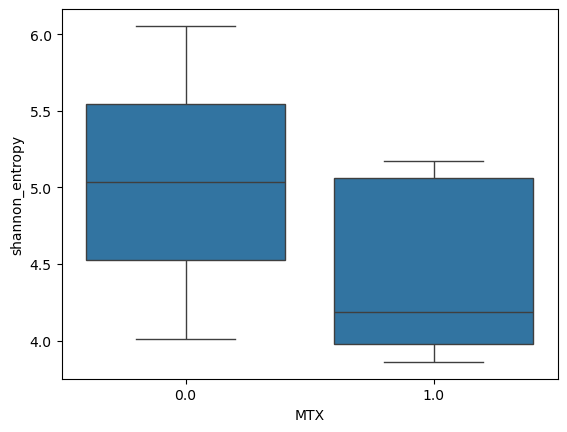

In [46]:
df = pd.concat([df_meta,df_med['MTX'],df_alpha['shannon_entropy']],axis=1)
df.to_csv(path + 'inputs/df_lmer.csv')#, sep='\t')
df = df[df['Diagnosis'] == 'RA']
# df
print(scipy.stats.ttest_ind(df[df['MTX']==0]['shannon_entropy'],df[df['MTX']==1]['shannon_entropy']))
sns.boxplot(y='shannon_entropy',x='MTX',data=df)

In [96]:
# merge lefses
df_lefse_taxa_uk = pd.read_csv(path + 'inputs/lefse_uk.tsv', sep='\t', index_col=0)

df_lefse_taxa_nyu = pd.read_csv(path + 'outputs/jobs06/lefse_results.tsv', sep='\t', header=None)
df_lefse_taxa_nyu.columns = ['Taxa','ESorMean_NYU','Group_NYU','LDA_NYU','p_value_NYU']
df_lefse_taxa_nyu = df_lefse_taxa_nyu.set_index('Taxa')

df_lefse_taxa_merge = pd.concat([df_lefse_taxa_uk,df_lefse_taxa_nyu],axis=1)
df_lefse_taxa_merge = df_lefse_taxa_merge.dropna(subset='p_value')

# otu l7
df_otu = pd.read_csv(path + 'outputs/jobs06/lefse_table.tsv', sep='\t', skiprows=2, index_col=0).T
df_otu.columns = df_otu.columns.map(lambda x: x.replace('|','.'))
df_otu.index = df_otu.index.map(lambda x: x + 'A')

# normalize
df_otu = df_otu.div(df_otu.sum(axis=1),axis=0)

# df combined
df_merge = pd.concat([df_meta,df_med['MTX'],df_alpha['shannon_entropy']],axis=1)

# for each taxa
for taxa in df_lefse_taxa_merge.index:
    cols = []
    for col in df_otu.columns:
        if taxa in col:
            cols.append(col)

    if len(cols) > 0:
        # print(taxa, cols)
        df_merge[taxa] = df_otu[cols].sum(axis=1)
        # break
    # sum all columns with those values
    

#df_lefse_taxa_merge['wsr_p']

#df_lefse_taxa_merge
# df_otu
df_merge.columns

Index(['TwinPair', 'Diagnosis', 'TJC', 'SJC', 'MTX', 'shannon_entropy',
       'k__Bacteria.p__Actinobacteria.c__Coriobacteriia',
       'k__Bacteria.p__Firmicutes.c__Bacilli',
       'k__Bacteria.p__Firmicutes.c__Clostridia.o__Clostridia_unclassified.f__Clostridia_unclassified.g__Clostridia_unclassified.s__Clostridia_bacterium',
       'k__Bacteria.p__Bacteroidetes.c__Bacteroidia.o__Bacteroidales.f__Bacteroidaceae.g__Bacteroides.s__Bacteroides_caccae',
       'k__Bacteria.p__Bacteroidetes.c__Bacteroidia.o__Bacteroidales.f__Tannerellaceae.g__Parabacteroides',
       'k__Bacteria.p__Bacteroidetes.c__Bacteroidia.o__Bacteroidales.f__Tannerellaceae.g__Parabacteroides.s__Parabacteroides_distasonis',
       'k__Bacteria.p__Proteobacteria.c__Gammaproteobacteria.o__Enterobacterales.f__Enterobacteriaceae.g__Escherichia',
       'k__Bacteria.p__Proteobacteria.c__Gammaproteobacteria.o__Enterobacterales.f__Enterobacteriaceae.g__Escherichia.s__Escherichia_coli'],
      dtype='object')

In [112]:
df_RA = df_merge[df_merge['Diagnosis']=='RA']
df_UA = df_merge[df_merge['Diagnosis']=='Unaffected']


ts = []
tps = []
wsrps = []
wrsps = []
dirs = []

for taxa in df_lefse_taxa_uk.index:
    try:
        ra = df_RA[taxa].values
        ua = df_UA[taxa].values
    
        t,p = scipy.stats.ttest_1samp(ra-ua,popmean=0) # RA-UA order
        if t > 0:
            dirs.append('Affected')
        elif t < 0:
            dirs.append('Unaffected')
        wsr,wsrp = scipy.stats.wilcoxon(ra,ua)
        wrs,wrsp = scipy.stats.mannwhitneyu(ra,ua)
        ts.append(np.round(t,3))
        tps.append(np.round(p,3))
        wsrps.append(np.round(wsrp,3))
        wrsps.append(np.round(wrsp,3))
    except:
        dirs.append('NA')
        ts.append('NA')
        tps.append('NA')
        wsrps.append('NA')
        wrsps.append('NA')
    
df_lefse_taxa_uk['t'] = ts
df_lefse_taxa_uk['t_pvalue'] = tps
df_lefse_taxa_uk['direction'] = dirs
df_lefse_taxa_uk['wsr_pvalue'] = wsrps
df_lefse_taxa_uk['wrs_pvalue'] = wrsps

df_lefse_taxa_uk.to_csv(path + 'inputs/df_lefse_taxa_uk_nyu.tsv', sep='\t')
df_lefse_taxa_uk.head()

,group,LDA,p_value,t,t_pvalue,direction,wsr_pvalue,wrs_pvalue
Taxa,,,,,,,,
k__Bacteria.p__Actinobacteria.c__Actinobacteria.o__Actinomycetales.f__Actinomycetaceae.g__Actinomyces.s__Actinomyces_sp_ICM58,Affected,2.48,0.012,NA,NA,NA,NA,NA
k__Bacteria.p__Actinobacteria.c__Actinobacteria.o__Actinomycetales.f__Actinomycetaceae.g__Actinomyces.s__Actinomyces_sp_ICM58.t__SGB17169,Affected,2.48,0.012,NA,NA,NA,NA,NA
k__Bacteria.p__Actinobacteria.c__Coriobacteriia,Affected,4.27,0.048,-0.004,0.997,Unaffected,0.945,0.721
k__Bacteria.p__Firmicutes.c__Bacilli,Affected,4.07,0.048,-0.516,0.622,Unaffected,0.844,0.959
k__Bacteria.p__Firmicutes.c__Clostridia.o__Clostridia_unclassified.f__Clostridia_unclassified.g__Clostridia_unclassified.s__Clostridia_bacterium,Affected,4.04,0.035,0.623,0.553,Affected,0.499,0.488


In [203]:
df_lefse_taxa_uk.index.values

array(['k__Bacteria.p__Actinobacteria.c__Actinobacteria.o__Actinomycetales.f__Actinomycetaceae.g__Actinomyces.s__Actinomyces_sp_ICM58',
       'k__Bacteria.p__Actinobacteria.c__Actinobacteria.o__Actinomycetales.f__Actinomycetaceae.g__Actinomyces.s__Actinomyces_sp_ICM58.t__SGB17169',
       'k__Bacteria.p__Actinobacteria.c__Coriobacteriia',
       'k__Bacteria.p__Firmicutes.c__Bacilli',
       'k__Bacteria.p__Firmicutes.c__Clostridia.o__Clostridia_unclassified.f__Clostridia_unclassified.g__Clostridia_unclassified.s__Clostridia_bacterium',
       'k__Bacteria.p__Firmicutes.c__Clostridia.o__Clostridia_unclassified.f__Clostridia_unclassified.g__Clostridia_unclassified.s__Clostridia_bacterium.t__SGB14854',
       'k__Bacteria.p__Bacteroidetes.c__Bacteroidia.o__Bacteroidales.f__Bacteroidaceae.g__Bacteroides.s__Bacteroides_caccae',
       'k__Bacteria.p__Bacteroidetes.c__Bacteroidia.o__Bacteroidales.f__Bacteroidaceae.g__Bacteroides.s__Bacteroides_caccae.t__SGB1877',
       'k__Bacteria.p__Bac

In [197]:
# taxa barplot
L_to_start_str = {
    'L2': '.c__', # for phylum you want to split on class
    'L3': '.o__',
    'L4': '.f__',
    'L5': '.g__',
    'L6': '.s__',
    'L7': 'NOTHING',
}
L_to_end_str = {
    'L2': '.p__', 
    'L3': '.c__',
    'L4': '.o__',
    'L5': '.f__',
    'L6': '.g__',
    'L7': '.s__'
}

df_otu2 = pd.read_csv(path + '/inputs/df_asv.tsv', sep='\t',skiprows=0,index_col=0)#, header=True)

l_to_taxa = {}
l_to_df = {}
for l in L_to_start_str:

    # get string to split on
    ss,es = L_to_start_str[l], L_to_end_str[l]


    # get taxa data
    df = df_otu2.copy() # .loc[keep,:]

    #if l != 'L7':
    #    df.columns = df.columns.map(lambda x: x.split(ss)[0])

    # normally this should happen AFTER the groupby but there's silly inconsistences
    # like bacillota === firmicutes but it's not consistent in the mapping
    
    # split string on ending '|'
    # df.columns = df.columns.map(lambda x: x.split(es)[-1])

    # this collapses taxa and sums up ones with same names
    df = df.groupby(df.columns, axis=1).sum()

    # taxa_tables.append(df)

    # transpose
    df = df.T

    # set name of index
    df.index.name = 'Taxon'

    # check that no dup rows
    if np.max(df.index.value_counts()) > 1:
        print('dup row')
    
    # save output
    # this is untidy format
    df.to_csv(path + 'inputs/df_taxa_' + l + '.tsv', sep='\t')
    l_to_df[l] = df

    
df

SampleID,500A,501A,502A,503A,504A,505A,506A,507A,508A,509A,510A,511A,512A,513A,514A,515A
Taxon,,,,,,,,,,,,,,,,
k Archaea|p Candidatus Thermoplasmatota|c Thermoplasmata|o Methanomassiliicoccales|f Methanomassiliicoccaceae|g Methanomassiliicoccaceae unclassified|s Methanomassiliicoccaceae unclassified SGB380,0.00000,0.000239,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
k Archaea|p Euryarchaeota|c Methanobacteria|o Methanobacteriales|f Methanobacteriaceae|g Methanobrevibacter|s Methanobrevibacter smithii,0.00003,0.011409,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000123,0.000000,0.000000,0.000000,0.000000,0.004630,0.000000
k Archaea|p Thaumarchaeota|c Thaumarchaeota unclassified|o Nitrosopumilales|f Nitrosopumilaceae|g Nitrosopumilus|s Nitrosopumilus SGB14899,0.00000,0.000000,0.0,0.000000,0.001290,0.000179,0.000029,0.000000,0.0,0.000000,0.000487,0.000000,0.000094,0.000000,0.000984,0.000395
k Bacteria|p Actinobacteria|c Actinomycetia|o Actinomycetales|f Actinomycetaceae|g Actinomyces|s Actinomyces SGB17154,0.00000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000020,0.000000,0.000000,0.000000
k Bacteria|p Actinobacteria|c Actinomycetia|o Actinomycetales|f Actinomycetaceae|g Fannyhessea|s Fannyhessea vaginae,0.00000,0.000000,0.0,0.000075,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
k Bacteria|p Synergistetes|c Synergistia|o Synergistales|f Synergistaceae|g GGB9469|s GGB9469 SGB14863,0.00000,0.000000,0.0,0.000000,0.000000,0.000000,0.001091,0.000000,0.0,0.000000,0.000000,0.000105,0.000000,0.000000,0.000000,0.000000
k Bacteria|p Tenericutes|c CFGB1787|o OFGB1787|f FGB1787|g GGB4745|s GGB4745 SGB6570,0.00000,0.000000,0.0,0.000000,0.000000,0.000000,0.015351,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
k Bacteria|p Verrucomicrobia|c Verrucomicrobiae|o Verrucomicrobiales|f Akkermansiaceae|g Akkermansia|s Akkermansia muciniphila,0.00000,0.009421,0.0,0.000000,0.000000,0.010926,0.010352,0.000601,0.0,0.000000,0.044276,0.000000,0.015001,0.023885,0.005809,0.000000


In [198]:
sig_taxa = []

taxa_tables = []

for l in L_to_start_str:
    df_otu = l_to_df[l].copy().T
    df_otu.index.name = 'SampleID'
    df_merge = pd.concat([df_meta['Diagnosis'],df_otu],axis=1)
    
    df_RA = df_merge[df_merge['Diagnosis']=='RA']
    df_UA = df_merge[df_merge['Diagnosis']=='Unaffected']

    taxas = []
    ts = []
    tps = []
    wsrps = []
    wrsps = []
    dirs = []
    
    for taxa in df_otu.columns.values:
        taxas.append(taxa)
        try:
            ra = df_RA[taxa].values
            ua = df_UA[taxa].values
        
            t,p = scipy.stats.ttest_1samp(ra-ua,popmean=0) # RA-UA order
            if t > 0:
                dirs.append('Affected')
            elif t < 0:
                dirs.append('Unaffected')
            wsr,wsrp = scipy.stats.wilcoxon(ra,ua)
            wrs,wrsp = scipy.stats.mannwhitneyu(ra,ua)
            ts.append(np.round(t,3))
            tps.append(np.round(p,3))
            wsrps.append(np.round(wsrp,3))
            wrsps.append(np.round(wrsp,3))
        except:
            dirs.append('NA')
            ts.append('NA')
            tps.append('NA')
            wsrps.append('NA')
            wrsps.append('NA')

    df_res = pd.DataFrame({'taxa': taxas, 
                          't': ts,
                          't_pvalue': tps,
                          'direction': dirs,
                          'wsr_pvalue': wsrps,
                          'wrs_pvalue': wrsps})
    taxa_tables.append(df_res)
    
df_final = pd.concat(taxa_tables,axis=0)
df_final


,taxa,t,t_pvalue,direction,wsr_pvalue,wrs_pvalue
0,k Archaea|p Candidatus Thermoplasmatota|c T...,-1.000,0.351,Unaffected,0.317,0.382
1,k Archaea|p Euryarchaeota|c Methanobacteria...,-0.534,0.610,Unaffected,0.593,0.945
2,k Archaea|p Thaumarchaeota|c Thaumarchaeota...,2.005,0.085,Affected,0.043,0.148
3,k Bacteria|p Actinobacteria|c Actinomycetia...,1.000,0.351,Affected,0.317,0.382
4,k Bacteria|p Actinobacteria|c Actinomycetia...,-1.000,0.351,Unaffected,0.317,0.382
...,...,...,...,...,...,...
685,k Bacteria|p Synergistetes|c Synergistia|o ...,0.888,0.404,Affected,0.655,1.000
686,k Bacteria|p Tenericutes|c CFGB1787|o OFGB...,1.000,0.351,Affected,0.317,0.382
687,k Bacteria|p Verrucomicrobia|c Verrucomicro...,0.602,0.566,Affected,0.917,0.866
688,k Bacteria|p Verrucomicrobia|c Verrucomicro...,1.000,0.351,Affected,0.317,0.382


In [201]:
df = df_final[df_final['wsr_pvalue'] < 0.05]
df.taxa.values

array(['k  Archaea|p  Thaumarchaeota|c  Thaumarchaeota unclassified|o  Nitrosopumilales|f  Nitrosopumilaceae|g  Nitrosopumilus|s  Nitrosopumilus SGB14899',
       'k  Bacteria|p  Firmicutes|c  CFGB1011|o  OFGB1011|f  FGB1011|g  GGB2653|s  GGB2653 SGB3574',
       'k  Bacteria|p  Firmicutes|c  CFGB1227|o  OFGB1227|f  FGB1227|g  GGB3005|s  GGB3005 SGB3996',
       'k  Bacteria|p  Firmicutes|c  CFGB3004|o  OFGB3004|f  FGB3004|g  GGB58158|s  GGB58158 SGB79798',
       'k  Bacteria|p  Firmicutes|c  Clostridia|o  Eubacteriales|f  Lachnospiraceae|g  Blautia|s  Blautia faecis',
       'k  Bacteria|p  Firmicutes|c  Clostridia|o  Eubacteriales|f  Lachnospiraceae|g  GGB3746|s  GGB3746 SGB5089',
       'k  Bacteria|p  Proteobacteria|c  Deltaproteobacteria|o  Desulfovibrionales|f  Desulfovibrionaceae|g  Bilophila|s  Bilophila wadsworthia',
       'k  Archaea|p  Thaumarchaeota|c  Thaumarchaeota unclassified|o  Nitrosopumilales|f  Nitrosopumilaceae|g  Nitrosopumilus|s  Nitrosopumilus SGB14899',
     

In [130]:
df_mc = pd.read_csv(path + 'outputs/jobs08/humann3_joined_pathabundance.tsv', sep='\t', index_col=0).T
df_mc.index = df_mc.index.map(lambda x: x.split('_')[0])
df_mc.index.name = 'SampleID'
df_mc = df_mc.drop(['UNMAPPED','UNINTEGRATED'],axis=1)

# normalize
df_mc = df_mc.div(df_mc.sum(axis=1),axis=0)
# df.sum(axis=1)




#df = df_lefse_taxa_uk.copy()
#sns.scatterplot(x='t_
df_lefse_path_uk = pd.read_csv(path + 'inputs/metacyc_twinsuk.txt', sep='\t', index_col=0)
#for x in df_lefse_path_uk.index:
#    y = x.split('PWY')
df_merge = df_lefse_path_uk.copy()

for fxn in df_lefse_path_uk.index:
    cols = []
    for col in df_mc.columns:
        if fxn in col:
            cols.append(col)

    if len(cols) > 0:
        print(fxn, cols)
        df_merge[fxn] = df_mc[cols].sum(axis=1)

df_merge

,group,LDA,p_value
Pathway,,,
COMPLETE_ARO_PWY_superpathwayofaromaticaminoacidbiosynthesis,Affected,3.02,0.035
P125_PWY_superpathwayof_R_R__butanediolbiosynthesis,Affected,2.06,0.047
PWY_4722_creatininedegradationII,Affected,2.07,0.048
PWY_6471_peptidoglycanbiosynthesisIV_Enterococcusfaecium_,Affected,2.97,0.048
AST_PWY_L_argininedegradationII_ASTpathway_,Unaffected,2.17,0.017
BIOTIN_BIOSYNTHESIS_PWY_biotinbiosynthesisI,Unaffected,2.79,0.048
CITRULBIO_PWY_L_citrullinebiosynthesis,Unaffected,2.84,0.025
FUC_RHAMCAT_PWY_superpathwayoffucoseandrhamnosedegradation,Unaffected,2.67,0.018
GLYCOLYSIS_TCA_GLYOX_BYPASS_superpathwayofglycolysis_pyruvatedehydrogenase_TCA_andglyoxylatebypass,Unaffected,2.80,0.017


In [155]:
df_mc_merge = df_mc.copy()
df_mc_merge.columns = df_mc_merge.columns.map(lambda x: x.split('|')[0])
df_mc_merge = df_mc_merge.groupby(lambda x:x, axis=1).sum()

queries = []
q_to_entry = {}
for x in df_mc_merge.columns.values:
    q = x.replace(': ','_')
    q = q.replace(' ','')
    q = q.replace('-','_')
    q_to_entry[q] = x
    queries.append(q)
    
for q in queries:
    for t in df_merge.index:
        if q in t:
            print(q,t,q_to_entry[q])

BIOTIN_BIOSYNTHESIS_PWY_biotinbiosynthesisI BIOTIN_BIOSYNTHESIS_PWY_biotinbiosynthesisI BIOTIN-BIOSYNTHESIS-PWY: biotin biosynthesis I
CITRULBIO_PWY_L_citrullinebiosynthesis CITRULBIO_PWY_L_citrullinebiosynthesis CITRULBIO-PWY: L-citrulline biosynthesis
COMPLETE_ARO_PWY_superpathwayofaromaticaminoacidbiosynthesis COMPLETE_ARO_PWY_superpathwayofaromaticaminoacidbiosynthesis COMPLETE-ARO-PWY: superpathway of aromatic amino acid biosynthesis
FUC_RHAMCAT_PWY_superpathwayoffucoseandrhamnosedegradation FUC_RHAMCAT_PWY_superpathwayoffucoseandrhamnosedegradation FUC-RHAMCAT-PWY: superpathway of fucose and rhamnose degradation
GLYOXYLATE_BYPASS_glyoxylatecycle GLYOXYLATE_BYPASS_glyoxylatecycle GLYOXYLATE-BYPASS: glyoxylate cycle
PWY_5705_allantoindegradationtoglyoxylateIII PWY_5705_allantoindegradationtoglyoxylateIII PWY-5705: allantoin degradation to glyoxylate III
PWY_6531_mannitolcycle PWY_6531_mannitolcycle PWY-6531: mannitol cycle
PWY_7323_superpathwayofGDP_mannose_derivedO_antigenbuilding

In [161]:
df = pd.concat([df_meta,df_med['MTX'],df_alpha['shannon_entropy']],axis=1)

df2 = df_mc_merge.copy()

df2.columns = df2.columns.map(lambda x: x.replace(': ','_').replace(' ','').replace('-','_'))


df_merge = pd.concat([df2,df],axis=1)




df_RA = df_merge[df_merge['Diagnosis']=='RA']
df_UA = df_merge[df_merge['Diagnosis']=='Unaffected']




ts = []
tps = []
wsrps = []
wrsps = []
dirs = []

for fxn in df_lefse_path_uk.index:
    try:
        ra = df_RA[fxn].values
        ua = df_UA[fxn].values
    
        t,p = scipy.stats.ttest_1samp(ra-ua,popmean=0) # RA-UA order
        if t > 0:
            dirs.append('Affected')
        elif t < 0:
            dirs.append('Unaffected')
        wsr,wsrp = scipy.stats.wilcoxon(ra,ua)
        wrs,wrsp = scipy.stats.mannwhitneyu(ra,ua)
        ts.append(np.round(t,3))
        tps.append(np.round(p,3))
        wsrps.append(np.round(wsrp,3))
        wrsps.append(np.round(wrsp,3))
    except:
        dirs.append('NA')
        ts.append('NA')
        tps.append('NA')
        wsrps.append('NA')
        wrsps.append('NA')
    
df_lefse_path_uk['t'] = ts
df_lefse_path_uk['t_pvalue'] = tps
df_lefse_path_uk['direction'] = dirs
df_lefse_path_uk['wsr_pvalue'] = wsrps
df_lefse_path_uk['wrs_pvalue'] = wrsps

df_lefse_path_uk.to_csv(path + 'inputs/df_lefse_fxn_uk_nyu.tsv', sep='\t')
df_lefse_path_uk.head()

,group,LDA,p_value,t,t_pvalue,direction,wsr_pvalue,wrs_pvalue
Pathway,,,,,,,,
COMPLETE_ARO_PWY_superpathwayofaromaticaminoacidbiosynthesis,Affected,3.02,0.035,-1.203,0.268,Unaffected,0.312,0.442
P125_PWY_superpathwayof_R_R__butanediolbiosynthesis,Affected,2.06,0.047,NA,NA,NA,NA,NA
PWY_4722_creatininedegradationII,Affected,2.07,0.048,NA,NA,NA,NA,NA
PWY_6471_peptidoglycanbiosynthesisIV_Enterococcusfaecium_,Affected,2.97,0.048,NA,NA,NA,NA,NA
AST_PWY_L_argininedegradationII_ASTpathway_,Unaffected,2.17,0.017,NA,NA,NA,NA,NA


In [163]:
df_lefse_path_uk

,group,LDA,p_value,t,t_pvalue,direction,wsr_pvalue,wrs_pvalue
Pathway,,,,,,,,
COMPLETE_ARO_PWY_superpathwayofaromaticaminoacidbiosynthesis,Affected,3.02,0.035,-1.203,0.268,Unaffected,0.312,0.442
P125_PWY_superpathwayof_R_R__butanediolbiosynthesis,Affected,2.06,0.047,NA,NA,NA,NA,NA
PWY_4722_creatininedegradationII,Affected,2.07,0.048,NA,NA,NA,NA,NA
PWY_6471_peptidoglycanbiosynthesisIV_Enterococcusfaecium_,Affected,2.97,0.048,NA,NA,NA,NA,NA
AST_PWY_L_argininedegradationII_ASTpathway_,Unaffected,2.17,0.017,NA,NA,NA,NA,NA
BIOTIN_BIOSYNTHESIS_PWY_biotinbiosynthesisI,Unaffected,2.79,0.048,-1.036,0.335,Unaffected,0.461,0.574
CITRULBIO_PWY_L_citrullinebiosynthesis,Unaffected,2.84,0.025,0.472,0.651,Affected,0.742,0.959
FUC_RHAMCAT_PWY_superpathwayoffucoseandrhamnosedegradation,Unaffected,2.67,0.018,-0.393,0.706,Unaffected,0.844,0.798
GLYCOLYSIS_TCA_GLYOX_BYPASS_superpathwayofglycolysis_pyruvatedehydrogenase_TCA_andglyoxylatebypass,Unaffected,2.80,0.017,NA,NA,NA,NA,NA


In [169]:
df1 = pd.read_csv('/Users/KevinBu/Desktop/clemente_lab/Projects/twinsra/inputs/RA_twins/16S/jobs/15_taxa/15_taxa_stats_clean.csv')
df1 = df1[df1['wilcoxon'] <= 0.1]
df1.feature.values
# df1


array(['Nitrosopumilus SGB14899', 'GGB2653 SGB3574', 'GGB3005 SGB3996',
       'GGB58158 SGB79798', 'Candidatus Cibionibacter quicibialis',
       'Eubacterium ramulus', 'Blautia faecis', 'GGB3746 SGB5089',
       'Dysosmobacter welbionis', 'Bilophila wadsworthia'], dtype=object)

In [170]:
df_lefse_taxa_uk.index.values

array(['k__Bacteria.p__Actinobacteria.c__Actinobacteria.o__Actinomycetales.f__Actinomycetaceae.g__Actinomyces.s__Actinomyces_sp_ICM58',
       'k__Bacteria.p__Actinobacteria.c__Actinobacteria.o__Actinomycetales.f__Actinomycetaceae.g__Actinomyces.s__Actinomyces_sp_ICM58.t__SGB17169',
       'k__Bacteria.p__Actinobacteria.c__Coriobacteriia',
       'k__Bacteria.p__Firmicutes.c__Bacilli',
       'k__Bacteria.p__Firmicutes.c__Clostridia.o__Clostridia_unclassified.f__Clostridia_unclassified.g__Clostridia_unclassified.s__Clostridia_bacterium',
       'k__Bacteria.p__Firmicutes.c__Clostridia.o__Clostridia_unclassified.f__Clostridia_unclassified.g__Clostridia_unclassified.s__Clostridia_bacterium.t__SGB14854',
       'k__Bacteria.p__Bacteroidetes.c__Bacteroidia.o__Bacteroidales.f__Bacteroidaceae.g__Bacteroides.s__Bacteroides_caccae',
       'k__Bacteria.p__Bacteroidetes.c__Bacteroidia.o__Bacteroidales.f__Bacteroidaceae.g__Bacteroides.s__Bacteroides_caccae.t__SGB1877',
       'k__Bacteria.p__Bac

In [217]:
from pingouin import partial_corr
df = pd.concat([df_meta,df_med['MTX'],df_alpha['shannon_entropy']],axis=1)
df = pd.get_dummies(data=df,columns=['Diagnosis','TwinPair'],dtype=int)
partial_corr(data=df, x='Diagnosis_RA', y='shannon_entropy', covar=['MTX','TwinPair'], method='pearson')

,n,r,CI95%,p-val
pearson,16,0.298158,"[-0.25, 0.7]",0.280422


In [218]:
df

,TJC,SJC,MTX,shannon_entropy,Diagnosis_RA,Diagnosis_Unaffected,TwinPair_T2,TwinPair_T3,TwinPair_T4,TwinPair_T5,TwinPair_T6,TwinPair_T7,TwinPair_T8,TwinPair_T9
500A,1,1,1.0,3.860518,1,0,1,0,0,0,0,0,0,0
501A,0,0,0.0,5.193414,0,1,1,0,0,0,0,0,0,0
502A,7,7,1.0,3.976850,1,0,0,1,0,0,0,0,0,0
503A,2,0,0.0,4.439629,0,1,0,1,0,0,0,0,0,0
504A,25,27,1.0,5.171083,1,0,0,0,1,0,0,0,0,0
505A,8,2,0.0,3.541273,0,1,0,0,1,0,0,0,0,0
506A,21,3,0.0,5.038667,1,0,0,0,0,1,0,0,0,0
507A,0,0,0.0,5.159244,0,1,0,0,0,1,0,0,0,0
508A,13,6,0.0,4.013039,1,0,0,0,0,0,1,0,0,0
509A,0,0,0.0,4.171476,0,1,0,0,0,0,1,0,0,0


##### Scratch? #####

In [110]:
# scipy.stats.ttest_1samp(ra-ua)
ra-ua

array([-1.96053116e-04, -3.99226564e-02,  0.00000000e+00, -1.07387222e-03,
        3.54714627e-05,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00])

In [82]:
# load in medication data
df_med = pd.read_csv(path + 'inputs/patient_data_meds.csv', skiprows=1)

# drop na rows
df_med = df_med.iloc[:20,:]

# convert subject to index and drop
df_med = df_med.set_index('Subject')
df_med.index = df_med.index.astype(int).astype(str)
df_med = df_med.drop(['183','182','516','517'])

# metadata subset
mcols = ['Abx', 'smoking previously', 'Alcohol current', 'NSAIDS current', 'NSAIDS last 3 mo']
df_med = df_med.loc[:,['Sibling_pair', 'Diagnosis'] + mcols]

# specific sub for 509
df_med.loc['509','smoking previously'] = 'y'

# convert 'na' to np.nan and run chi sq
for m in mcols:
    print(m)
    df_med[m] = df_med[m].apply(lambda x: np.nan if x == 'na' else x)

    # binarize column
    df_med[m] = df_med[m].apply(lambda x: 'n' if x in ['No abx', 'n'] else 'y')
 
    # get contingency matrix
    contingency_table = pd.crosstab(df_med['Diagnosis'], df_med[m])
    print(contingency_table)

    # compute chi2
    chi2, p, dof, expected = scipy.stats.chi2_contingency(contingency_table)
    
    print("Chi-Square statistic:", chi2)
    print("P-value:", p)

df_med.head()

Abx
Abx           n  y
Diagnosis         
1_Unaffected  4  4
2_RA          5  3
Chi-Square statistic: 0.0
P-value: 1.0
smoking previously
smoking previously  n  y
Diagnosis               
1_Unaffected        4  4
2_RA                3  5
Chi-Square statistic: 0.0
P-value: 1.0
Alcohol current
Alcohol current  n  y
Diagnosis            
1_Unaffected     4  4
2_RA             4  4
Chi-Square statistic: 0.0
P-value: 1.0
NSAIDS current
NSAIDS current  n  y
Diagnosis           
1_Unaffected    4  4
2_RA            3  5
Chi-Square statistic: 0.0
P-value: 1.0
NSAIDS last 3 mo
NSAIDS last 3 mo  n  y
Diagnosis             
1_Unaffected      0  8
2_RA              2  6
Chi-Square statistic: 0.5714285714285714
P-value: 0.4496917979688908


,Sibling_pair,Diagnosis,Abx,smoking previously,Alcohol current,NSAIDS current,NSAIDS last 3 mo
Subject,,,,,,,
501,sib_01,1_Unaffected,y,n,n,n,y
503,sib_02,1_Unaffected,y,y,y,n,y
505,sib_03,1_Unaffected,n,n,n,n,y
507,sib_04,1_Unaffected,n,y,y,y,y
509,sib_05,1_Unaffected,n,y,n,n,y


In [41]:
# check for diversity as a function of metadata difference
df = df_med.copy()

pairs = df['Sibling_pair'].unique()

df_dict = {
    'Sibling_pair': pairs
}
# collect paired values
for m in mcols:
    df_UA = df[df['Diagnosis'] == '1_Unaffected'].set_index('Sibling_pair')
    df_RA = df[df['Diagnosis'] == '2_RA'].set_index('Sibling_pair')
    df_dict[m + '_diff'] = df_RA[m].replace(['y','n'],[1,0]) - df_UA[m].replace(['y','n'],[1,0]) 

df = pd.DataFrame(df_dict)
df.index = df.index.map(lambda x: 'T' + str(int(x.split('_0')[-1]) + 1))
df = df.drop('Sibling_pair', axis=1)
df

,Abx_diff,smoking previously_diff,Alcohol current_diff,NSAIDS current_diff,NSAIDS last 3 mo_diff
Sibling_pair,,,,,
T2,-1,0,0,1,0
T3,0,0,0,1,0
T4,0,1,1,0,-1
T5,1,-1,0,0,0
T6,0,0,0,1,0
T7,-1,0,-1,-1,-1
T8,1,0,0,-1,0
T9,-1,1,0,0,0


In [42]:
# test corr 
df_merge = pd.concat([df, df_paired_alpha, df_paired_beta], axis=1)

# for each metadata difference, test each q dff
qcols = ['shannon_entropy_diff', 'Bray_Curtis', 'MTX', 'SJC', 'TJC']
for m in mcols:
    for q in qcols:
        f, p = scipy.stats.f_oneway(*[gp[q] for g, gp in df_merge.groupby(m + '_diff')])
        if p < 0.05:
            r, p = scipy.stats.pearsonr(df_merge[m + '_diff'], df_merge[q])
            print(m,q)
            print(p)

        plt.figure(figsize=(4,3))
        sns.scatterplot(data=df_merge, x=m + '_diff', y=q)
        sns.despine()
        plt.tight_layout()
        plt.savefig(path + 'outputs/jobs22/' + m + '_' + q + '.pdf')
        plt.close()

df_merge.to_csv(path + 'inputs/df_glm_R.csv')
df_merge.head()

smoking previously shannon_entropy_diff
0.04608584897606692
Alcohol current SJC
0.011992044791843633
NSAIDS current TJC
0.76955186851755


,Abx_diff,smoking previously_diff,Alcohol current_diff,NSAIDS current_diff,NSAIDS last 3 mo_diff,shannon_entropy_diff,Bray_Curtis,MTX,SJC,TJC
T2,-1,0,0,1,0,-1.332895,0.705551,1.0,1,1
T3,0,0,0,1,0,-0.462779,0.474034,1.0,7,7
T4,0,1,1,0,-1,1.629810,0.685602,1.0,27,25
T5,1,-1,0,0,0,-0.120577,0.725669,0.0,3,21
T6,0,0,0,1,0,-0.158437,0.757568,0.0,6,13


In [70]:
# intra_pair beta, lowest for T3 and T8
df_paired_beta

,Bray_Curtis,MTX,SJC,TJC
T2,0.705551,1.0,1,1
T3,0.474034,1.0,7,7
T4,0.685602,1.0,27,25
T5,0.725669,0.0,3,21
T6,0.757568,0.0,6,13
T7,0.839525,1.0,0,0
T8,0.452763,1.0,1,4
T9,0.648924,0.0,5,12


SignificanceResult(statistic=0.2735294117647059, pvalue=0.3053231563074052)
SignificanceResult(statistic=0.38095238095238104, pvalue=0.35181255311756476)
SignificanceResult(statistic=0.28571428571428575, pvalue=0.4927262450169573)
SignificanceResult(statistic=-0.7142857142857144, pvalue=0.04652823228416724)


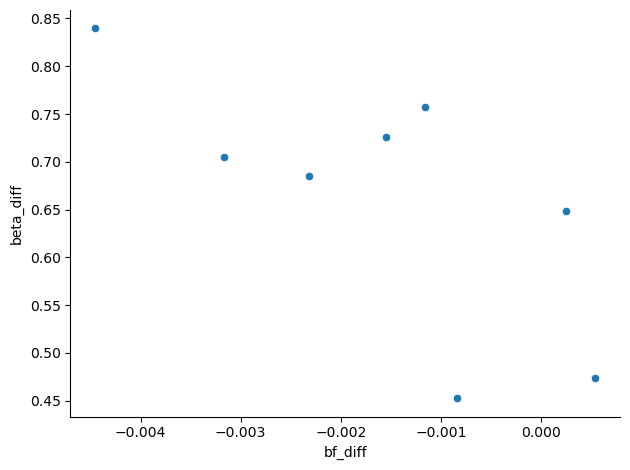

In [80]:
# testing associatoin of diversity 
div = 'shannon_entropy'
bf = 'k  Bacteria|p  Firmicutes|c  Clostridia|o  Eubacteriales|f  Lachnospiraceae|g  Blautia|s  Blautia faecis'
df_merge = pd.concat([df_alpha, df_otu[bf]],axis=1)
# df_merge = df_merge.drop(['502A', '503A'])

print(scipy.stats.spearmanr(df_merge[div], df_merge[bf]))

df_RA = df_merge[df_merge['Diagnosis'] == 'RA']
df_UA = df_merge[df_merge['Diagnosis'] == 'Unaffected']

print(scipy.stats.spearmanr(df_RA[div], df_RA[bf]))

print(scipy.stats.spearmanr(df_RA[div].values - df_UA[div].values, df_RA[bf].values - df_UA[bf].values))

# beta
print(scipy.stats.spearmanr(df_paired_beta['Bray_Curtis'], df_RA[bf].values - df_UA[bf].values))
# print(scipy.stats.spearmanr(df_paired_beta.drop('T3')['Bray_Curtis'], df_RA[bf].values - df_UA[bf].values))

# 
df_merge = pd.DataFrame({'beta_diff': df_paired_beta['Bray_Curtis'], 'bf_diff': df_RA[bf].values - df_UA[bf].values})

sns.scatterplot(data=df_merge, x='bf_diff', y='beta_diff')
sns.despine()
plt.tight_layout()


In [52]:
print(df_RA[bf].values - df_UA[bf].values)
df_paired_beta

[-0.00316979  0.00053966 -0.00232258 -0.00155014 -0.00116292 -0.00445142
 -0.00083639  0.00024919]


,Bray_Curtis,MTX,SJC,TJC
T2,0.705551,1.0,1,1
T3,0.474034,1.0,7,7
T4,0.685602,1.0,27,25
T5,0.725669,0.0,3,21
T6,0.757568,0.0,6,13
T7,0.839525,1.0,0,0
T8,0.452763,1.0,1,4
T9,0.648924,0.0,5,12


In [84]:
# df_fa
bf = 'k  Bacteria|p  Firmicutes|c  Clostridia|o  Eubacteriales|f  Lachnospiraceae|g  Blautia|s  Blautia faecis'
df_merge = pd.concat([df_fa, df_otu[bf], df_dx],axis=1)
# df_merge = df_merge.drop(['502A', '503A'])
# df_merge = df_merge.dropna(how='any')

for fa in df_fa.columns:
    print(fa)
    print(scipy.stats.spearmanr(df_merge[fa], df_merge[bf], nan_policy='omit'))
    df_plot = pd.concat([df_merge[fa], df_merge[bf]], axis=1)
    df_plot = df_plot.dropna()
    print(scipy.stats.pearsonr(df_plot[fa], df_plot[bf]))
    
    df_RA = df_merge[df_merge['Diagnosis'] == 'RA']
    df_UA = df_merge[df_merge['Diagnosis'] == 'Unaffected']

    plt.figure(figsize=(6,4))
    sns.scatterplot(data=df_merge, x=bf, y=fa, hue='Diagnosis')
    sns.despine()
    plt.tight_layout()
    plt.savefig(path + 'outputs/jobs22/bf_fa_corrs/bf_' + fa + '.pdf') 
    plt.close()
    
    dfa = df_RA[fa] #- df_UA[fa].values
    dbf = df_RA[bf] #- df_UA[bf].values
    print(scipy.stats.spearmanr(dfa.values, dbf.values, nan_policy='omit'))
    df_plot = pd.concat([dfa, dbf], axis=1)
    df_plot = df_plot.dropna()    
    print(scipy.stats.pearsonr(df_plot[fa], df_plot[bf]))

    df_merged = pd.DataFrame({'diff_bf': dbf, 'diff_' + fa: dfa})
    plt.figure(figsize=(6,4))
    sns.scatterplot(data=df_merged, x='diff_bf', y='diff_' + fa)
    sns.despine()
    plt.tight_layout()
    plt.savefig(path + 'outputs/jobs22/bf_fa_corrs/bf_' + fa + '_diff.pdf') 
    plt.close()


Acetate 
SignificanceResult(statistic=0.45, pvalue=0.09235737494812253)
PearsonRResult(statistic=0.3745870399424124, pvalue=0.16893963710591794)
SignificanceResult(statistic=0.3571428571428572, pvalue=0.38512064355625636)
PearsonRResult(statistic=-0.09353532514884613, pvalue=0.825641489546712)
Propionate 
SignificanceResult(statistic=0.28214285714285714, pvalue=0.3082844568200554)
PearsonRResult(statistic=0.09141021464076574, pvalue=0.7459413071183899)
SignificanceResult(statistic=0.30952380952380953, pvalue=0.4556448907375822)
PearsonRResult(statistic=-0.1536364661994486, pvalue=0.7164326014219166)
Butyrate 
SignificanceResult(statistic=0.22857142857142856, pvalue=0.41256617049636035)
PearsonRResult(statistic=0.19543739622845313, pvalue=0.4851541034122076)
SignificanceResult(statistic=0.30952380952380953, pvalue=0.4556448907375822)
PearsonRResult(statistic=0.31802134547591104, pvalue=0.4426949949127731)
Isovalerate 
SignificanceResult(statistic=0.010714285714285714, pvalue=0.969769876

In [57]:
df_merge[fa]

500A      18.961611
501A      23.364729
502A       6.222841
503A      11.350637
504A      26.324529
505A      40.646318
506A       9.933258
508A       5.415508
509A     333.730602
510A       3.006532
511A      25.632757
512A     666.873182
513A     132.694466
514A     801.416089
515A    2976.820507
507A            NaN
Name: Dodecanoic_acid, dtype: float64

In [40]:
# CUTIE pathway plots
x =  'Metabolism|Biosynthesis of other secondary metabolites|Monobactam biosynthesis'
df = pd.concat([df_path[x], df_dx, df_quant.loc[:,['CXCL1']]],axis=1)
df.columns = ['Monobactam_biosynthesis','Diagnosis','CXCL1']
df.to_csv(path + 'outputs/jobs02/df_mb.tsv', sep='\t')
df.head()

x = 'Metabolism|Metabolism of other amino acids|Cyanoamino acid metabolism'
df = pd.concat([df_path[x], df_dx, df_quant.loc[:,['CXCL1']]],axis=1)
df.columns = ['Cyanoamino_acid_metabolism','Diagnosis','CXCL1']
df.to_csv(path + 'outputs/jobs02/df_ca.tsv', sep='\t')
df.head()

,Cyanoamino_acid_metabolism,Diagnosis,CXCL1
500A,0.001914,RA,7.062380
501A,0.001631,Unaffected,6.989813
502A,0.002139,RA,8.102450
503A,0.001869,Unaffected,7.471897
504A,0.002183,RA,9.101940


In [ ]:
%%capture
# pathway analysis
# collect individual pathway dfs
#pathway_fps = pathlib.Path(path + 'outputs/ensemble_humann3/').glob('*A_genefamilies.tsv')
# pathway_fps = pathlib.Path(path + 'outputs/ensemble_humann3/').glob('*A_pathabundance.tsv')

# collect and parse dfs
#dfs = []
#for fp in pathway_fps:
#    df = pd.read_csv(path + 'outputs/ensemble_humann3/' + fp.name, sep='\t', index_col=0)
#    df = df/df.sum()
#    dfs.append(df)

# merge dataframes
#df_pathway = pd.concat(dfs, axis=1).T
df_pathway = pd.read_csv(path + 'outputs/jobs08/humann3_joined_pathabundance.tsv', sep='\t',index_col=0)

# drop UNINTEGRATED, UNMAPPED
df_pathway = df_pathway.drop(['UNINTEGRATED','UNMAPPED'])

# replace nan with 0
df_pathway = df_pathway.replace(np.nan,0)

# transpose and normalize
df_pathway = df_pathway.T
df_pathway = df_pathway.div(df_pathway.sum(axis=1),axis=0)

# test first x pathways
# df_pathway = df_pathway.iloc[:,:100]

# conduct KW test
RA_ids = ['512A_Abundance',#-RPKs', 
          '508A_Abundance',#-RPKs', 
          '514A_Abundance',#-RPKs',
          '502A_Abundance',#-RPKs',
          '500A_Abundance',#-RPKs',
          '510A_Abundance',#-RPKs',
          '504A_Abundance']#-RPKs',

UA_ids = ['513A_Abundance',#-RPKs', 
          '509A_Abundance',#-RPKs', 
          '515A_Abundance',#-RPKs',
          '503A_Abundance',#-RPKs', 
          '501A_Abundance',#-RPKs',
          '511A_Abundance',#-RPKs',
          '505A_Abundance']#-RPKs']

pathways = list(df_pathway.columns.values)

# SR ONLY
names = []
tvals = []
pvals = []
test = []
direction = []

for x in pathways:
    plot = False
    RA_vals = df_pathway.loc[RA_ids,x].values
    UA_vals = df_pathway.loc[UA_ids,x].values
    try:
        #h,p = scipy.stats.kruskal(RA_vals, UA_vals)
        if np.median(RA_vals) > np.median(UA_vals):
            d = 'RA'
        else:
            d = 'UA'
        #names.append(x)
        #tvals.append(h)
        #pvals.append(p)
        #test.append('KW')
        #direction.append(d)
        #if p<0.05:
        #    plot = True
        diff = RA_vals - UA_vals
        if sum(np.isnan(diff)) < 2:
            w,p = scipy.stats.wilcoxon(RA_vals, UA_vals)
            names.append(x)
            tvals.append(w)
            pvals.append(p)
            test.append('SR')
            direction.append(d)
            if p < 0.05:
                plot = True
    except:
        plot = False
    if plot:
        #sns.stripplot([RA_vals, UA_vals])
        sns.boxplot([RA_vals, UA_vals])
        plt.title(x)
        plt.savefig(path + 'outputs/jobs08/sig_metacyc/' + x + '.pdf',  bbox_inches="tight")
        plt.close()

df_sigpath = pd.DataFrame.from_dict({
    'pathway': names,
    'test_stat': tvals,
    'pvalue': pvals,
    'test': test,
    'direction': direction
})
df_sigpath = df_sigpath.set_index('pathway')
df_sigpath['FDR_bh'] = scipy.stats.false_discovery_control(df_sigpath['pvalue'].values)
df_sigpath_FDR = df_sigpath[df_sigpath['FDR_bh'] < 0.05]
df_sigpath = df_sigpath[df_sigpath['pvalue'] < 0.05] 
df_sigpath.to_csv(path + 'outputs/jobs08/df_sigpath.tsv', sep='\t')
df_sigpath_FDR.to_csv(path + 'outputs/jobs08/df_sigpath_FDR.tsv', sep='\t')

print(len(df_sigpath)) # should be 27
df_sigpath.head()

In [ ]:
%%capture
# pathway analysis for KO
# collect individual pathway dfs
#pathway_fps = pathlib.Path(path + 'outputs/ensemble_humann3/').glob('*A_genefamilies.tsv')
# pathway_fps = pathlib.Path(path + 'outputs/ensemble_humann3/').glob('*A_pathabundance.tsv')
# df_pathway = pd.read_csv(path + 'outputs/ensemble_humann3/humann3_joined_KO_no_misses_relabund_nobar_brite.tsv', sep='\t')
df_pathway = pd.read_csv(path + 'outputs/jobs08/humann3_joined_KO_no_misses_relabund_stratified_brite.tsv', sep='\t')#,index_col=0)

# set index and transpose
df_pathway = df_pathway.set_index('pathways')
df_pathway = df_pathway.T

# rename samples
df_pathway.index = df_pathway.index.map(lambda x: x.split('_')[0] + '_Abundance')

# test first x pathways
# df_pathway = df_pathway.iloc[:,:100]

# conduct KW test
RA_ids = ['512A_Abundance',#-RPKs', 
          '516A_Abundance',#-RPKs',
          '508A_Abundance',#-RPKs', 
          '514A_Abundance',#-RPKs',
          '502A_Abundance',#-RPKs',
          '500A_Abundance',#-RPKs',
          '510A_Abundance',#-RPKs',
          '504A_Abundance']#-RPKs',

UA_ids = ['513A_Abundance',#-RPKs', 
          '517A_Abundance',#-RPKs', 
          '509A_Abundance',#-RPKs', 
          '515A_Abundance',#-RPKs',
          '503A_Abundance',#-RPKs', 
          '501A_Abundance',#-RPKs',
          '511A_Abundance',#-RPKs',
          '505A_Abundance']#-RPKs']

pathways = list(df_pathway.columns.values)

names = []
tvals = []
pvals = []
test = []

for x in pathways:
    plot = False
    RA_vals = df_pathway.loc[RA_ids,x].values
    UA_vals = df_pathway.loc[UA_ids,x].values
    try:
        #h,p = scipy.stats.kruskal(RA_vals, UA_vals)
        #if p < 0.05:
        #    names.append(x)
        #    tvals.append(h)
        #    pvals.append(p)
        #    test.append('KW')
        #    plot = True
        diff = RA_vals - UA_vals
        if sum(np.isnan(diff)) < 2:
            w,p = scipy.stats.wilcoxon(RA_vals, UA_vals)
            names.append(x)
            tvals.append(w)
            pvals.append(p)
            test.append('SR')
            if p < 0.05:
                plot = True
    except:
        plot = False
    if plot:
        #sns.stripplot([RA_vals, UA_vals])
        sns.boxplot([RA_vals, UA_vals])
        plt.title(x)
        plt.savefig(path + 'outputs/ensemble_humann3/sig_ko/' + x + '.pdf',  bbox_inches="tight")
        plt.close()

df_sigpath = pd.DataFrame.from_dict({
    'pathway': names,
    'test_stat': tvals,
    'pvalue': pvals,
    'test': test
})
df_sigpath = df_sigpath.set_index('pathway')
df_sigpath['FDR_bh'] = scipy.stats.false_discovery_control(df_sigpath['pvalue'].values)
df_sigpath_FDR = df_sigpath[df_sigpath['FDR_bh'] < 0.05]
df_sigpath = df_sigpath[df_sigpath['pvalue'] < 0.05] 
df_sigpath.to_csv(path + 'outputs/jobs08/df_sigko.tsv', sep='\t')
df_sigpath_FDR.to_csv(path + 'outputs/jobs08/df_sigko_FDR.tsv', sep='\t')

print(len(df_sigpath_FDR)) # should be 0, before or after FDR
df_sigpath_FDR.head()

In [ ]:
# identify specific FA producers
df_pathway = pd.read_csv(path + 'outputs/jobs08/humann3_joined_pathabundance.tsv', sep='\t',index_col=0)

# drop UNINTEGRATED, UNMAPPED
df_pathway = df_pathway.drop(['UNINTEGRATED','UNMAPPED'])

# replace nan with 0
df_pathway = df_pathway.replace(np.nan,0)

# transpose and normalize
df_pathway = df_pathway.T
df_pathway = df_pathway.div(df_pathway.sum(axis=1),axis=0)

pathways = list(df_pathway.columns.values)

# specific queries
queries = ['butanoate','octanoate']

# IDs of samples; dropped twin pair that didn't have FA measurement?
RA_ids = ['512A_Abundance',#-RPKs', 
          '508A_Abundance',#-RPKs', 
          '514A_Abundance',#-RPKs',
          '502A_Abundance',#-RPKs',
          '500A_Abundance',#-RPKs',
          '510A_Abundance',#-RPKs',
          '504A_Abundance']#-RPKs',

UA_ids = ['513A_Abundance',#-RPKs', 
          '509A_Abundance',#-RPKs', 
          '515A_Abundance',#-RPKs',
          '503A_Abundance',#-RPKs', 
          '501A_Abundance',#-RPKs',
          '511A_Abundance',#-RPKs',
          '505A_Abundance']#-RPKs']

for q in queries:
    for x in pathways:
        pathway = x.lower()
        if q in pathway:
            RA_vals = df_pathway.loc[RA_ids,x].values
            UA_vals = df_pathway.loc[UA_ids,x].values
            h,p = scipy.stats.kruskal(RA_vals, UA_vals)
            if p < 0.05:
                print(x)
                print('KW')
                print(p)
            diff = RA_vals - UA_vals
            if sum(np.isnan(diff)) < 2:
                w,p = scipy.stats.wilcoxon(RA_vals, UA_vals)
                if p<0.05:
                    print(x)
                    print('RS')
                    print(p)
            sns.boxplot([RA_vals, UA_vals])
            plt.title(x)
            plt.savefig(path + 'outputs/ensemble_humann3/' + q +'/' + x + '.pdf',  bbox_inches="tight")
            plt.close()        

        
    #if 'fatty acid' in x.lower():
    #    print(x)
    # if 'fatty acid' in pathway:
    #    if 'mitochondria' not in pathway:
    #        print(x)


In [ ]:
# pseudo perm test chi square 
# iterate and grab each df post dropping near zero var
import scipy
import sklearn.metrics
import itertools
import random

random.seed(0)

name_to_df = {
    'olink':df_olink,
    'fa': df_fa,
    'acpa_fecal': df_acpa_fecal,
    'acpa_plasma': df_acpa_plasma,
    'mb': df_mb,
    'asv_filt': df_asv_filt,
    'path_filt': df_path_filt,
    'asv': df_asv.drop(['Diagnosis'],axis=1),
    'path': df_path.drop(['Diagnosis','TwinPair'],axis=1),
    'quant_R': pd.concat([df_quant, df_asv.drop(['Diagnosis'],axis=1), df_path.drop(['Diagnosis','TwinPair'],axis=1)], axis=1)
}
# each row will be data type, num clusters, type of test/association, and p value
df_arr = []
k_arr = []
stat_arr = []
p_arr = []

# max cluster iter
k_max = 6

for x in name_to_df:
    print(x)
    df = pd.read_csv(path + 'outputs/jobs19/mat_' + x + '_meta.tsv',sep='\t') # written from R code
    if x == 'fa':
        df.index = df_meta_edit.index.drop('507A')
        df = pd.concat([df_meta_edit.drop('507A'), df], axis=1)
    else:
        df.index = df_meta_edit.index
        df = pd.concat([df_meta_edit, df], axis=1)

    if x == 'quant_R':
        df = df.drop('507A')
    
    # get distance matrix
    mdata = df.loc[:,['TwinPair','Diagnosis','TJC','SJC']]
    data = df.drop(['TwinPair','Diagnosis','TJC','SJC'],axis=1)
    if x == 'quant_R':
        data = data.values.astype(float)
    condensed_dist = scipy.spatial.distance.pdist(data, metric='euclidean')
    # noncond_dist = distance.squareform(condensed_dist)
    
    # get linkages from dist matrix
    linkages = scipy.cluster.hierarchy.linkage(condensed_dist, method='average', metric='euclidian')
    
    for k in range(2,k_max+1):
        # [1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1]
        cut = scipy.cluster.hierarchy.fcluster(linkages, k, criterion='maxclust')
    
        # we want completeness of twinpair per cluster (all twins from same pair in same cluster)
        # and we want homogeneity of disease state per cluster (clusters should be as unfiorm as possible)
        # we can construct a statistical test via non parametric permutation testing of shuffling of labels (either TP or Dx)
        # given the same tree structure/cluster partitioning, so we keep cut the same and shuttle the labels
    
        # for the twins
        true=mdata['TwinPair'].values
        perm_cs = []
        # do arbitrarily a subset of 1000 perms 
        n_perm = 100
        for i in range(n_perm):
            perm = random.sample(list(true), k=len(true))
            perm_cs.append(sklearn.metrics.completeness_score(labels_true=perm, labels_pred=cut))
    
        true_cs = sklearn.metrics.completeness_score(labels_true=true, labels_pred=cut)
    
        percentile = scipy.stats.percentileofscore(perm_cs, true_cs)
        df_arr.append(x)
        k_arr.append(k)
        stat_arr.append('TwinPair_completeness')
        p_arr.append((100-percentile)/100) 
        
        # for the dx
        true=mdata['Diagnosis'].values
        perm_cs = []
        n_perm = 100
        for i in range(n_perm):
            perm = random.sample(list(true), k=len(true))
            perm_cs.append(sklearn.metrics.homogeneity_score(labels_true=perm, labels_pred=cut))
    
        true_cs = sklearn.metrics.homogeneity_score(labels_true=true, labels_pred=cut)
    
        percentile = scipy.stats.percentileofscore(perm_cs, true_cs)
        df_arr.append(x)
        k_arr.append(k)
        stat_arr.append('Diagnosis_homogeneity')
        p_arr.append((100-percentile)/100) 

        for var in ['TJC','SJC']:
            mdata['cluster'] = cut
            vecs = []
            for i in range(1, k+1):
                vecs.append(list(mdata[mdata['cluster'] == i][var].values))
            
            H,p = scipy.stats.kruskal(*vecs)
            df_arr.append(x)
            k_arr.append(k)
            stat_arr.append(var + '_KW')
            p_arr.append((100-percentile)/100) 

df_results = pd.DataFrame.from_dict({'DataType':df_arr,
                                     'n_clust':k_arr,
                                     'statistic':stat_arr,
                                     'pval':p_arr})

df_results[df_results['pval'] < 0.05]

In [ ]:
# inter intra dist, a similar idea to above about completeness/homogeneity
str_to_df = {
    'df_mb': df_mb,
    'df_olink': df_olink,
    'df_fa': df_fa,
    'df_acpa_plasma': df_acpa_plasma,
    'df_acpa_fecal': df_acpa_fecal,
    'df_path_filt': df_path_filt
}


for name in str_to_df:
    print(name)
    meta_var = name
    df_var = str_to_df[name].astype(float)

    # subtract each col value by the mean and divide by standard dev
    df_var_std = (df_var - df_var.mean())/df_var.std()
    
    # from earlier analyses, pair_to_ids maps 'T2': ('501A','500A')
    # if name = 'df_fa' drop the T5 pair
    pair_to_dist = {}
    for p in pair_to_ids:
        id_UA, id_RA = pair_to_ids[p]
        if name == 'df_fa':
            if p == 'T5':
                continue
        pair_to_dist[p] = np.linalg.norm(df_var_std.loc[id_UA,:].values-df_var_std.loc[id_RA,:].values)
    
    df_paired_var = pd.DataFrame.from_dict(pair_to_dist, orient='index', columns=['OLINK'])
    
    # merge with diagnosis data
    df_var_meta = pd.concat([df_dx, df_var],axis=1)
    
    # get df_raw from distances
    id_to_dist = {}
    
    samples = list(df_var.index.values)
    SubjectID1 = []
    SubjectID2 = []
    Group1 = []
    Group2 = []
    Distance = []
    
    for i in range(len(samples)):
        for j in range(i):
            SubjectID1.append(samples[j])
            SubjectID2.append(samples[i])
            Group1.append(df_map.loc[samples[j],'Diagnosis'])
            Group2.append(df_map.loc[samples[i],'Diagnosis'])
            temp = df_var_std.loc[[samples[j],samples[i]],:]
            temp = temp.dropna(how='any',axis=1)
            Distance.append(np.linalg.norm(temp.loc[samples[j],:].values-temp.loc[samples[i],:].values))
    
    df_raw = pd.DataFrame.from_dict({'SubjectID1':SubjectID1, 
                                     'SubjectID2':SubjectID2, 
                                     'Group1':Group1, 
                                     'Group2': Group2, 
                                     'Distance': Distance}, orient='columns')#, columns=['OLINK'])
    
                        
    # get split DFs
    df_RA = df_raw[df_raw['Group1'] == 'RA']
    df_RA = df_RA[df_RA['Group2'] == 'RA']
    df_UA = df_raw[df_raw['Group1'] == 'Unaffected']
    df_UA = df_UA[df_UA['Group2'] == 'Unaffected']
    
    # compare distances
    inter_twin = df_paired_beta['Bray_Curtis'].values
    inter_RA = df_RA['Distance'].values
    inter_UA = df_UA['Distance'].values
    
    u, p = scipy.stats.mannwhitneyu(inter_twin, inter_RA)
    print(u, p)
    
    t, p = scipy.stats.ttest_ind(inter_twin, inter_RA)
    #print(t, p)
    
    t, p = scipy.stats.ttest_ind(inter_UA, inter_RA)
    # print(t, p)
    
    f, p = scipy.stats.f_oneway(inter_UA, inter_RA, inter_twin)
    print(f, p)
    
    category = ['intra_twin_pair']*len(inter_twin) + ['inter_RA_only']*len(inter_RA) + ['inter_UA_only']*len(inter_UA)
    distances = list(inter_twin) + list(inter_RA) + list(inter_UA)
    df_dist = pd.DataFrame(data=np.array([category,distances]).T, columns=['category',meta_var + ' distance'])
    df_dist[meta_var + ' distance'] = df_dist[meta_var + ' distance'].astype(float)
    df_dist.to_csv(path + 'outputs/jobs10/inter_intra_' + meta_var + '_dist.tsv',sep='\t')
                         
    sns.boxplot(data=df_dist, x='category', y=meta_var + ' distance')
    sns.swarmplot(data=df_dist, x='category', y=meta_var + ' distance', color='black')
    plt.savefig(path + 'outputs/jobs10/plot_inter_intra_' + meta_var + '.pdf',  bbox_inches="tight")
    plt.close()


In [ ]:
# get # of TP correlations with and without FDR
from statsmodels.stats.multitest import multipletests

# jobs17 UA, jobs18 RA taxa
# jobs20 RA, jobs21 UA pathways
var_to_job = {
    'UA_taxa': 'jobs17',
    'RA_taxa': 'jobs18',
    'RA_path': 'jobs20',
    'UA_path': 'jobs21'}



# grab relevant correlations
for v in var_to_job:
    print(v)
    for a in ['noFDR']:#,'FDR']:
        print(a)
        # load dataframe of interest
        df = pd.read_csv(path + 'outputs/' + var_to_job[v] + '/data_processing/summary_df_resample_1.txt', sep='\t')

        # focus on var of interest
        if v.split('_')[-1] == 'taxa':
            # grab taxa of interest and pathways of interest
            taxa_df = pd.read_csv(path + 'inputs/RA_twins/16S/jobs/15_taxa/15_taxa_stats_clean.csv')
            var_int = list(taxa_df[taxa_df['wilcoxon'] < 0.05]['feature'].values)
            var_int = var_int + ['Bilophila wadsworthia']
            var_int = ['k  Bacteria|p  Firmicutes|c  Clostridia|o  Eubacteriales|f  Lachnospiraceae|g  Blautia|s  Blautia faecis',
                       'k  Bacteria|p  Proteobacteria|c  Deltaproteobacteria|o  Desulfovibrionales|f  Desulfovibrionaceae|g  Bilophila|s  Bilophila wadsworthia']

        elif v.split('_')[-1] == 'path':            
            path_df = pd.read_csv(path + 'inputs/RA_twins/16S/jobs/16_path/16_path_stats_clean.csv')
            var_int = list(path_df[path_df['wilcoxon'] < 0.05]['feature'].values)
            var_int = [y.replace('|', '_').replace('/', '__').replace('\\', '__') for y in var_int]
            df['var1'] = [x.replace('|', '_').replace('/', '__').replace('\\', '__') for x in list(df['var1'])]

        # for each var of interest
        print(var_int)
        counter=0
        for f in var_int:
            print(f)
            # df_f = df[df['var1'].str.contains(f)]
            df_f = df[df['var1'] == f]
            print(len(df_f))

            # FDR 
            if a == 'FDR':
                df_f['padjust'] = multipletests(df_f['pvalues'], method='fdr_bh')[1]
                df_f = df_f[df_f['padjust'] < 0.05]
            # filter on TP
            df_f = df_f[df_f['class'] == 'TP']
            counter += len(df_f['var2'].values)

            # summarize results
            print(len(df_f['var2'].values))
        print('Total')
        print(counter)
            # print(df_f['var2'].values)
df_f.head()

In [ ]:
# jobs17 UA, jobs18 RA
df = pd.read_csv(path + 'outputs/jobs17/data_processing/summary_df_resample_1.txt', sep='\t')
df = df[df['var1'] == 'k  Bacteria|p  Firmicutes|c  Clostridia|o  Eubacteriales|f  Lachnospiraceae|g  Blautia|s  Blautia faecis']
# df = df[df['var1'] == 'k  Bacteria|p  Proteobacteria|c  Deltaproteobacteria|o  Desulfovibrionales|f  Desulfovibrionaceae|g  Bilophila|s  Bilophila wadsworthia']


df['padjust'] = multipletests(df['pvalues'], method='fdr_bh')[1]
df = df[df['class'] == 'TP']
print(len(df))
bf_var2 = df['var2'].values
df2 = df[df['padjust'] < 0.05]
print(len(df2))

# find intersect with differential ACPAs from fecal and plasma
df_acpa = pd.read_csv(path + 'inputs/RA_twins/16S/jobs/10_acpa_fecal/acpa_fecal_stats_clean.csv')
df_acpa = df_acpa[df_acpa['ttest'] < 0.05]
diffs_fecal = list(df_acpa['acpa fecal analyte'].values)
diffs_fecal = [x.replace(' I','_I') for x in diffs_fecal]
diffs_fecal = [x + '_Fecal' for x in diffs_fecal]

df_acpa = pd.read_csv(path + 'inputs/RA_twins/16S/jobs/11_acpa_plasma/acpa_plasma_stats_clean.csv')
df_acpa = df_acpa[df_acpa['ttest'] < 0.05]
diffs_plasma = list(df_acpa['acpa plasma analyte'].values)
diffs_plasma = [x.replace(' I','_I') for x in diffs_plasma]
diffs_plasma = [x + '_Plasma' for x in diffs_plasma]


#df = df[df['var2'].isin(['SCF','Flt3L'] + diffs_fecal + diffs_plasma)]
#print(['SCF','Flt3L'] + diffs_fecal + diffs_plasma)
#print(df['var2'].values)
df = df[df['correlations'] > 0]
df
# df

In [ ]:
# CUTIE plots
x =  'k  Bacteria|p  Firmicutes|c  Clostridia|o  Eubacteriales|f  Lachnospiraceae|g  Blautia|s  Blautia faecis'
df = pd.concat([df_asv_filt[x], df_dx, df_quant.loc[:,bf_var2[0:2]]],axis=1)
df.columns = ['Blautia_faecis','Diagnosis','Flt3L','SCF']#,'ApoE_277_296_Cit2_sm2_cyclic_IgG_fecal','FibrinogenB_54_72_IgA_fecal','Fibrinogen_IgA_fecal']
df.to_csv(path + 'outputs/jobs02/df_bf.tsv', sep='\t')
df.head()

x =  'k  Bacteria|p  Proteobacteria|c  Deltaproteobacteria|o  Desulfovibrionales|f  Desulfovibrionaceae|g  Bilophila|s  Bilophila wadsworthia'
df = pd.concat([df_asv_filt[x], df_dx, df_quant.loc[:,bw_var2]],axis=1)
df.columns = ['Bilophila_wadsworthia','Diagnosis','IL7','TNFB']
df.to_csv(path + 'outputs/jobs02/df_bw.tsv', sep='\t')
df.head()

In [ ]:
# perform cohen's D
def cohens_d_2s(group1, group2):
    """
    Calculate Cohen's d for two groups.

    Parameters:
    group1, group2 (array-like): The two groups for which to calculate Cohen's d.

    Returns:
    d (float): The computed Cohen's d value.
    """
    mean1, mean2 = np.mean(group1), np.mean(group2)
    var1, var2 = np.var(group1, ddof=1), np.var(group2, ddof=1)
    n1, n2 = len(group1), len(group2)

    pooled_std = np.sqrt(((n1 - 1) * var1 + (n2 - 1) * var2) / (n1 + n2 - 2))
    d = (mean1 - mean2) / pooled_std

    return d


def cohens_d_1s(group):
    """
    """
    mean = np.mean(group)
    var = np.var(group, ddof=1)
    n = len(group)
    d = mean / np.sqrt(var)

    return d

def mad(data):
    """
    Median absolute difference
    """
    median = np.median(data)
    deviations = np.abs(data - median)
    mad = np.median(deviations)
    return mad

def mag_d_1s(B):
    return np.median(B) / np.sqrt((mad(B) ** 2)/2)

def mag_d_2s(A, B):
    return (np.median(B) - np.median(A)) / np.sqrt((mad(A) ** 2 + mad(B) ** 2)/2)

    
# Example usage:
# group1 = [1, 2, 3, 4, 5]
# group2 = [3, 4, 5, 6, 7]

# effect_size = cohens_d(group1, group2)
# print("Cohen's d:", effect_size)

str_to_df = {
    'df_mb': df_mb,
    'df_olink': df_olink,
    'df_fa': df_fa,
    'df_acpa_plasma': df_acpa_plasma,
    'df_acpa_fecal': df_acpa_fecal,
    'df_asv': df_asv.drop('Diagnosis',axis=1),
    'df_path': df_path.drop(['Diagnosis','TwinPair'],axis=1)
}


# for each dataframe / data type 
# compute the top differential features via t-test
# except for asv and path, which you should take the top from wilcoxon
 
var = []
pv = []
stat = []
cd2s = []
cd1s = []
dtype = []
md2s = []
md1s = []

for d in str_to_df:
    print(d)
    # grab df and merge with dx metadata
    df_orig = str_to_df[d]
    # d = 'df_fa'
    # df = df_fa.copy()    
    df = pd.concat([df_meta_edit, df_orig], axis=1)
    if d == 'df_fa':
        df = df.drop(['506A','507A'])
    
    features = list(df.columns.values)[4:]
    pairs = list(set(df.TwinPair.values))
    
    df_RA = df[df['Diagnosis'] == 'RA']
    df_UA = df[df['Diagnosis'] == 'Unaffected']
    
    
    for f in features:
        # get the vectors for each diagnosis
        diffs = []
        RA_vals = []
        UA_vals = []
        for t in pairs:
            twin_df = df[df['TwinPair'] == t]
            fRAt = twin_df[twin_df['Diagnosis'] == 'RA'][f].values.astype(float)[0]
            fUAt = twin_df[twin_df['Diagnosis'] == 'Unaffected'][f].values.astype(float)[0]
            diffs.append(fRAt - fUAt)
            RA_vals.append(fRAt)
            UA_vals.append(fUAt)
    
        # do paired testing
        if d in ['df_asv','df_path']:
            t,p = scipy.stats.wilcoxon(RA_vals, UA_vals)
        else:
            t,p = scipy.stats.ttest_rel(RA_vals, UA_vals)
    
        if p < 0.05:
            stat.append(t)
            pv.append(p)
            var.append(f)
            dtype.append(d)

    
        
            # get unpaired vectors 
            fRA = df[df['Diagnosis'] == 'RA'][f].astype(float).values
            fUA = df[df['Diagnosis'] == 'Unaffected'][f].astype(float).values
            cd_up = cohens_d_2s(fRA, fUA)
            cd_p = cohens_d_1s(diffs)
    
            cd2s.append(cd_up)
            cd1s.append(cd_p)

            md_up = mag_d_2s(fRA, fUA)
            md_p = mag_d_1s(diffs)
            
            md2s.append(md_up)
            md1s.append(md_p)
        
df_results = pd.DataFrame({'dtype': dtype,
                           'feature': var,
                           'pval': pv,
                           'test_stat': stat,
                           'cohens_d_unpaired': cd2s,
                           'cohens_d_paired': cd1s,
                           'mag_d_unpaired': md2s,
                           'mag_d_paired': md1s})

df_results['cohens_d_unpaired_abs'] = df_results['cohens_d_unpaired'].apply(lambda x: np.abs(x))
df_results['cohens_d_paired_abs'] = df_results['cohens_d_paired'].apply(lambda x: np.abs(x))
df_results['mag_d_unpaired_abs'] = df_results['mag_d_unpaired'].apply(lambda x: np.abs(x))
df_results['mag_d_paired_abs'] = df_results['mag_d_paired'].apply(lambda x: np.abs(x))

df_results.to_csv(path + 'inputs/cohensd_pretest.tsv', sep='\t')
df_results.head()


In [ ]:
# sort by unpaired
metrics = ['Mag_D','Cohens_D']
for m in metrics:
    metric_p = m.lower() + '_paired_abs'
    metric_up = m.lower() + '_unpaired_abs'
    
    sort_2s_df = df_results.sort_values(metric_p, ascending=False)
    sort_1s_df = df_results.sort_values(metric_up, ascending=False)
    
    # get first three entires of each row
    sort_2s_df = sort_2s_df.groupby('dtype').head(3)
    sort_1s_df = sort_1s_df.groupby('dtype').head(3)
    
    # export to df
    # sort_2s_df.to_csv(path + 'inputs/sort_2s_df.tsv', sep='\t')
    # sort_1s_df.to_csv(path + 'inputs/sort_1s_df.tsv', sep='\t')
    
    # preview
    df = sort_1s_df.copy()
    # df = df[df['dtype'] != 'df_path']
    df['Direction'] = df['cohens_d_paired'].apply(lambda x: 'Unaffected' if x < 0 else 'RA')
    df = df.drop(['pval','test_stat','dtype'],axis=1)

    # melt
    df = pd.melt(df, id_vars=['feature','Direction'], value_vars=[metric_up, metric_p], var_name='Measure', value_name='Value')
    
    # rename for formatting
    df['Measure'] = df['Measure'].replace({metric_up: m + '_Unpaired', metric_p: m + '_Paired'})
    df = df[df['Measure'] == m + '_Paired']
    # trim features
    # df['feature'] = df['feature'].apply(lambda x: x[-25:])
    a =  'k  Bacteria|p  Firmicutes|c  Clostridia|o  Eubacteriales|f  Lachnospiraceae|g  Blautia|s  Blautia faecis'
    b =  'k  Bacteria|p  Proteobacteria|c  Deltaproteobacteria|o  Desulfovibrionales|f  Desulfovibrionaceae|g  Bilophila|s  Bilophila wadsworthia'
    mapping = {a: 'Blautia faecis', b: 'Bilophila wadsworthia'}
    df['feature'] = df['feature'].replace(mapping)

    a = 'Metabolism|Xenobiotics biodegradation and metabolism|Atrazine degradation',
    b = 'Metabolism|Biosynthesis of other secondary metabolites|Biosynthesis of various plant secondary metabolites'
    c = 'Metabolism|Amino acid metabolism|Lysine biosynthesis'
    mapping = {a: 'Atrazine degradation', b: 'Biosynthesis of Plant Secondary Metabolites', c: 'Lysine biosynthesis'}
    df['feature'] = df['feature'].replace(mapping)
    
    df = df[df['feature'] != 'k  Bacteria|p  Firmicutes|c  Clostridia|o  Eubacteriales|f  Lachnospiraceae|g  GGB3746|s  GGB3746 SGB5089']
    df = df[df['feature'] != 'k  Bacteria|p  Firmicutes|c  CFGB3004|o  OFGB3004|f  FGB3004|g  GGB58158|s  GGB58158 SGB79798']
    df = df[df['feature'] != 'Bilophila wadsworthia']
    df.to_csv(path + 'inputs/' + m.lower() + '_1s_test_df.tsv', sep='\t')

df


In [ ]:
df.loc[[16,25,26],:].feature.values

In [ ]:
# perform random forest 
from sklearn.model_selection import cross_val_score,cross_val_predict,  KFold,  LeaveOneOut, StratifiedKFold
from sklearn.metrics import roc_curve, auc
from sklearn import datasets
from sklearn.datasets import load_wine
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import RocCurveDisplay
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

diagnosis = df_num['BinDiag']

# get X and y data
X, y = df_num.drop('BinDiag',axis=1).values, df_num['BinDiag'].values

str_to_df = {
    'df_mb': df_mb,
    'df_olink': df_olink,
    'df_fa': df_fa,
    'df_acpa_plasma': df_acpa_plasma,
    'df_acpa_fecal': df_acpa_fecal,
    'df_asv': df_asv_filt,
    'df_path': df_path_filt
}


for name in str_to_df:
    print(name)
    df = str_to_df[name]
    # get columns of interest
    features = [x.strip() for x in list(df.columns.values)]
    
    # subset df_rf
    df_test = df_rf[features]
    
    # merge with diagnosis binarized
    df_test = pd.concat([df_test, diagnosis], axis=1)

    # complete cases
    df_test = df_test.dropna(axis=0)
    
    # separate data and labels
    X, y = df_test.drop('BinDiag',axis=1).values, df_test['BinDiag'].values

    # set fold split
    kf = LeaveOneOut()
    # kf = KFold(n_splits=3)
    
    # try SVC
    # clf = SVC(kernel='linear', class_weight='balanced', probability=True, random_state=42)
    clf = SVC(probability=True, random_state=42)
    all_y = []
    all_probs=[]
    for train, test in kf.split(X, y):
        all_y.append(y[test])
        all_probs.append(clf.fit(X[train], y[train]).predict_proba(X[test])[:,1])
    all_y = np.array(all_y)
    all_probs = np.array(all_probs)

    fpr, tpr, thresholds = roc_curve(all_y,all_probs)
    roc_auc = auc(fpr, tpr)
    print('SVC')
    print(roc_auc)
        
    # try RF
    # clf = RandomForestClassifier(n_estimators=100, random_state=42, max_depth=10)
    clf = RandomForestClassifier(n_estimators=100, random_state=42)
    all_y = []
    all_probs=[]
    for train, test in kf.split(X, y):
        all_y.append(y[test])
        all_probs.append(clf.fit(X[train], y[train]).predict_proba(X[test])[:,1])
    all_y = np.array(all_y)
    all_probs = np.array(all_probs)

    fpr, tpr, thresholds = roc_curve(all_y,all_probs)
    roc_auc = auc(fpr, tpr)
    print('RF')
    print(roc_auc)
    #print(all_probs)


In [ ]:
# load in the new dataframe of pts
df_rb = pd.read_csv('/Users/KevinBu/Desktop/clemente_lab/Projects/twinsra/inputs/Patient_data.csv', skiprows=1)
df_rb = df_rb.iloc[0:20,:]
df_rb['Subject'] = df_rb['Subject'].map(lambda x: str(int(x)) + 'A')
df_rb = df_rb.set_index('Subject')
df_rb['DAS28-CRP'] = df_rb['DAS28-CRP'].astype(float)
df_rb = df_rb.drop(['182A','183A'])
df_rb = df_rb.rename(columns={'CRP (performed 12/2023 on serum)':'CRP'})
df_rb['Sibling_pair'] = df_rb['Sibling_pair'].map(lambda x: 'T' + str(int(x.split('_')[1])+1))
df_rb = df_rb[df_rb['Sibling_pair'] != 'T10']
# create new col for ordinal disease activity based on CRP DAS28
'''
remission =< 2.6
low dis activity >2.6 - 3.2
mod dis activity > 3.2 - 5.1
hi dis activity >5.1
'''
conditions = [
    (df_rb['DAS28-CRP'] <= 2.6),
    (df_rb['DAS28-CRP'] > 2.6) & (df_rb['DAS28-CRP'] <= 3.2),
    (df_rb['DAS28-CRP'] > 3.2) & (df_rb['DAS28-CRP'] <= 5.1),
    (df_rb['DAS28-CRP'] > 5.1)
]
choices = ['remission', 'low', 'moderate','high']
df_rb['disease_severity'] = np.select(conditions, choices, default='nan')

# subset columns we want
df_rb = df_rb.loc[:,['disease_severity','CRP','DAS28-CRP','Sibling_pair','Diagnosis']]

# get paired version
pair_to_diff = {}
for p in list(df_rb['Sibling_pair'].values):
    df = df_rb[df_rb['Sibling_pair'] == p]
    vals_UA = float(df[df['Diagnosis'] == '1_Unaffected']['CRP'].values)
    vals_RA = float(df[df['Diagnosis'] == '2_RA']['CRP'].values)
    pair_to_diff[p] = vals_RA - vals_UA

df_paired_CRP = pd.DataFrame.from_dict(pair_to_diff, orient='index', columns=['CRP_diff'])

pair_to_diff = {}
for p in list(df_rb['Sibling_pair'].values):
    df = df_rb[df_rb['Sibling_pair'] == p]
    vals_UA = float(df[df['Diagnosis'] == '1_Unaffected']['DAS28-CRP'].values)
    vals_RA = float(df[df['Diagnosis'] == '2_RA']['DAS28-CRP'].values)
    pair_to_diff[p] = vals_RA - vals_UA

df_paired_DC = pd.DataFrame.from_dict(pair_to_diff, orient='index', columns=['DAS28-CRP_diff'])


df_paired_final = pd.concat([df_paired_alpha, df_paired_beta, df_paired_CRP, df_paired_DC], axis=1)
df_paired_final

In [ ]:
# correlations non paired
#x = 'Shannon_Diff'
#x = 'Bray_Curtis'
#y = 'CRP_diff'
#y = 'DAS28-CRP_diff'
# take df_alpha 
df_alpha_mod = df_alpha.copy()

# add col with SJC TJC
df_alpha_mod['SJC'] = df_alpha_mod.index.map(samp_to_SJC)
df_alpha_mod['TJC'] = df_alpha_mod.index.map(samp_to_TJC)


# df_beta tbd since it is a distance matrix not PCoA coords yet
df_corr = pd.concat([df_alpha_mod, df_rb[['CRP','disease_severity','DAS28-CRP']]], axis=1)

# df_corr.head()

df_corr = df_corr[df_corr['Diagnosis'] == 'RA']
for x in [alpha_metric]:
    for y in ['SJC','TJC','CRP','DAS28-CRP']:
        r, p = scipy.stats.spearmanr(a=df_corr[x],b=df_corr[y])
        # sns.lmplot(data=df_corr, x=x, y=y)
        print(r, p)


In [ ]:
df_corr2 = df_corr.drop(['disease_severity'],axis=1)
df_corr2 = df_corr2.rename({'DAS28-CRP':'DAS28_CRP'},axis=1)
df_corr2.to_csv(path + 'outputs/jobs02/df_corr.tsv',sep='\t')
df_corr2

In [ ]:
df_corr3 = pd.concat([df_corr2.set_index('TwinPair'), df_paired_beta['Bray_Curtis']], axis=1)
for x in ['Bray_Curtis']:
    for y in ['SJC','TJC','CRP','DAS28_CRP']:
        r, p = scipy.stats.spearmanr(a=df_corr3[x],b=df_corr3[y])
        # ns.lmplot(data=df_corr3, x=x, y=y)
        print(r, p)
df_corr3.to_csv(path + 'outputs/jobs02/df_corr3.tsv', sep='\t')
df_corr3


In [ ]:
# process pathway results into lefse able format
df = pd.read_csv(path + '/inputs/RA_Twins/16S/jobs/16_path/16_path_stats_clean.csv')
df = df[df['wilcoxon'] <= 0.05]
df['Group'] = df['wilcox stat'].map(lambda x: 'RA' if x >= 18 else 'Unaffected')
df['wilcoxshift'] = df['wilcox stat'].map(lambda x: x-18)
df_lp = df[['feature', 'wilcox stat', 'Group', 'wilcoxshift', 'wilcoxon']].set_index('feature')
df_lp.to_csv(path + 'outputs/jobs06/pathway_results.tsv', sep='\t', header=False)
df_lp


In [ ]:
# comparin